
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 1<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Symbolic Regression <br>


---

### Student Number = 403206519

### Full Name = Fatemeh Shahhosseini

---

# Introduction

This notebook explores two methods for performing symbolic regression, focusing on both traditional and modern AI-driven approaches:

## 1. EQL-Based Symbolic Regression  
The first approach we implement is based on **Equation Learner (EQL)**, a neural network-based symbolic regression technique. EQL leverages neural networks with activation functions that encourage the discovery of symbolic expressions, making it a differentiable and trainable approach for learning equations directly from data. This method helps in bridging the gap between deep learning and symbolic reasoning.

## 2. Seq2Seq-Based Symbolic Regression with Transformers
A more recent and powerful approach to symbolic regression leverages Sequence-to-Sequence (Seq2Seq) models using Transformers. In this method, we frame symbolic regression as a translation problem, where the input consists of numerical data points and the output is a corresponding mathematical expression. By training a Transformer model on pairs of input data and symbolic expressions, we can enable it to generalize and infer underlying symbolic patterns. This approach benefits from the self-attention mechanism, allowing it to capture long-range dependencies in mathematical structures effectively.


# Datasets

We use two datasets to evaluate our methods:

- **Dataset 1:** This dataset is provided in the notebook, and its underlying mathematical formula is explicitly given. It serves as a reference to assess the performance of different symbolic regression approaches. The expression we consider is: `2 * x + np.sin(x) + x * np.sin(x)`.
  
- **Dataset 2:** This dataset is also provided with the notebook, but its underlying mathematical relationship is hidden. Throughout different parts of the notebook, you will attempt to uncover the equation governing this dataset. Your responses will be evaluated based on how accurately you recover the true formula.

By working through both datasets, we aim to test the robustness and accuracy of various symbolic regression techniques while providing an engaging and exploratory learning experience.

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import numpy as np
import sympy as sp
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from inspect import signature
import time
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sympy
import glob
import time
import signal
import random
import warnings
import json
import re

warnings.filterwarnings('ignore')

# Generate Dataset

In [ ]:
def generate_data(func, N, range_min=-2, range_max=2, noise_std=0.1):
    """
    Generates a dataset by evaluating the given function on random input values with added noise.

    Parameters:
    func (callable): A function that takes numerical inputs and returns a scalar output.
    N (int): The number of data points to generate.
    range_min (float, optional): The minimum value of the input range. Default is -2.
    range_max (float, optional): The maximum value of the input range. Default is 2.
    noise_std (float, optional): Standard deviation of Gaussian noise added to function outputs. Default is 0.1.

    Returns:
    tuple: A tuple (x, y) where:
        - x (torch.Tensor): A tensor of shape (N, x_dim), where x_dim is the number of inputs to func.
        - y (torch.Tensor): A tensor of shape (N, 1) containing the noisy function outputs.
    """

    x_dim = len(signature(func).parameters)  # Number of inputs to the function
    x = (range_max - range_min) * torch.rand([N, x_dim]) + range_min
    y = torch.tensor([[func(*x_i)] for x_i in x], dtype=torch.float32)

    # Adding Gaussian noise
    noise = torch.randn(y.shape) * noise_std
    y_noisy = y + noise

    return x, y_noisy

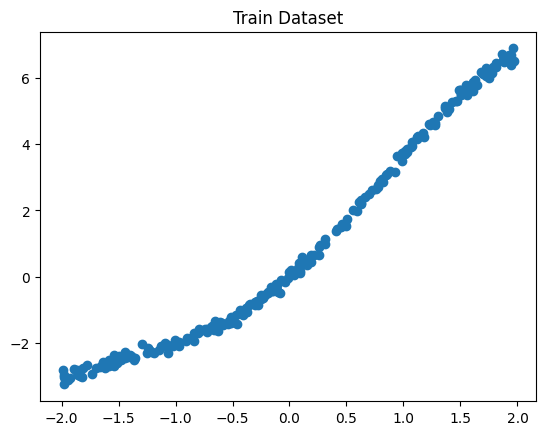

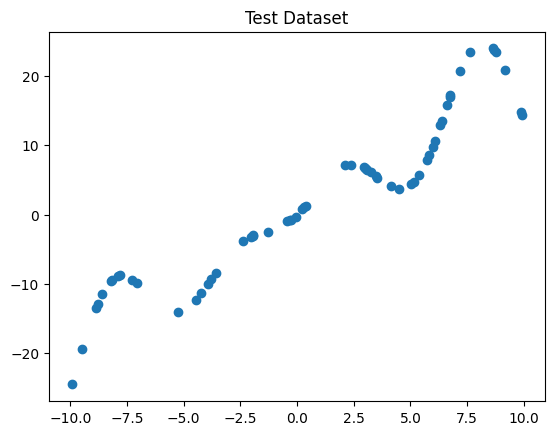

In [ ]:
# Define train and test first dataset

x_train, y_train = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 240, -2, 2)
plt.scatter(x_train, y_train)
plt.title('Train Dataset')
plt.show()

# We change range_min and range_max here to test its OOD (out-of-distribution) performance

x_test, y_test = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 60, -10, 10)
plt.scatter(x_test, y_test)
plt.title('Test Dataset')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the second dataset
df = pd.read_csv("/content/drive/MyDrive/NeuroSymbolic/symbolic regression/dataset.csv")

# Step 2: Extract features and target
X = df[["x_1", "x_2"]].values
y = df["y"].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Step 3: Split into training and testing sets
x_train_ood, x_test_ood, y_train_ood, y_test_ood = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
type(x_train_ood)

torch.Tensor

In [ ]:
x_train_ood.shape, x_train.shape

(torch.Size([40, 2]), torch.Size([240, 1]))

# EQL

Equation Learner (EQL) is a neural network-based approach to symbolic regression that discovers mathematical expressions directly from data. Unlike traditional deep learning models that treat regression as a black-box approximation, EQL is designed to output interpretable symbolic expressions. EQL uses a special type of neural network where activation functions are not just standard non-linearities (like ReLU or sigmoid) but include mathematical operations such as addition, multiplication, and trigonometric functions (e.g., sin(x), cos(x)).

<p align="center">
  <img style="margin-top: 30px" src="https://camo.githubusercontent.com/f4722b552bd6d4bd3909ff054ebef8bc4a973d9dd93e2ccacd6c77f4e03e3443/68747470733a2f2f692e696d6775722e636f6d2f485a58776656492e706e67" width="1000">
</p>

### Retrieve expressions

This cell is used to retrieve expressions from the network. Do not modify this cell.

In [ ]:
# DON'T CHNAGE THIS CELL

"""
Generate a mathematical expression for the symbolic regression get_expression (also known as the EQL network) using SymPy.
This expression can be utilized for pretty-printing in various formats, including human-readable text and LaTeX.
Additionally, SymPy enables algebraic manipulation of the expression.
"""


def apply_activation(W, funcs, n_double=0):
    """Given an (n, m) matrix W and (m) vector of funcs, apply funcs to W.

    Arguments:
        W:  (n, m) matrix
        funcs: list of activation functions (SymPy functions)
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        SymPy matrix with 1 column that represents the output of applying the activation functions.
    """
    W = sp.Matrix(W)
    if n_double == 0:
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j] = funcs[j](W[i, j])
    else:
        # print("n_double: ", n_double)
        W_new = W.copy()
        out_size = len(funcs)
        for i in range(W.shape[0]):
            in_j = 0
            out_j = 0
            while out_j < out_size - n_double:
                # print("up", in_j, out_j)
                W_new[i, out_j] = funcs[out_j](W[i, in_j])
                in_j += 1
                out_j += 1
            while out_j < out_size:
                if in_j == out_size:
                  in_j -= 1
                # print("down", in_j, out_j)
                W_new[i, out_j] = funcs[out_j](W[i, in_j], W[i, in_j+1])
                in_j += 2
                out_j += 1
        for i in range(n_double):
            W_new.col_del(-1)
        W = W_new
    return W


def sym_pp(W_list, funcs, var_names, threshold=0.01, n_double=0):
    """Pretty print the hidden layers (not the last layer) of the symbolic regression network

    Arguments:
        W_list: list of weight matrices for the hidden layers
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        Simplified sympy expression.
    """
    vars = []
    for var in var_names:
        if isinstance(var, str):
            vars.append(sp.Symbol(var))
        else:
            vars.append(var)
    expr = sp.Matrix(vars).T
    # W_list = np.asarray(W_list)
    for W in W_list:
        W = filter_mat(sp.Matrix(W), threshold=threshold)
        # print("expr: ",expr.shape, "W shape: ", W.shape)
        # expr = expr * W #expr:  (1, 1) W shape:  (18, 1)
        expr = expr * W.T
        expr = apply_activation(expr, funcs, n_double=n_double)
    # expr = expr * W_list[-1]
    return expr



def last_pp(eq, W):
    """Pretty print the last layer."""
    W = W.T
    return eq * filter_mat(sp.Matrix(W))


def count_inputs(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction):
            i += 1
        elif isinstance(func, BaseFunction2):
            i += 2
    return i


def count_double(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction2):
            i += 1
    return i


def get_expression(weights, funcs, var_names, threshold=0.01):
    """Pretty print the entire symbolic regression network.

    Arguments:
        weights: list of weight matrices for the entire network
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.

    Returns:
        Simplified sympy expression."""
    n_double = count_double(funcs)
    funcs = [func.sp for func in funcs]

    expr = sym_pp(weights[:-1], funcs, var_names, threshold=threshold, n_double=n_double)
    expr = last_pp(expr, weights[-1])
    expr = expr[0, 0]
    return expr


def filter_mat(mat, threshold=0.01):
    """Remove elements of a matrix below a threshold."""
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i, j]) < threshold:
                mat[i, j] = 0
    return mat


def filter_expr(expr, threshold=0.01):
    expr_new = sp.Integer(0)
    for arg in expr.args:
        if arg.is_constant() and abs(arg) > threshold:   # hack way to check if it's a number
            expr_new = expr_new + arg
        elif not arg.is_constant() and abs(arg.args[0]) > threshold:
            expr_new = expr_new + arg
    return expr_new


def filter_expr2(expr, threshold=0.01):
    for a in sp.preorder_traversal(expr):
        if isinstance(a, sp.Float) and a < threshold:
            expr = expr.subs(a, 0)
    return expr

### Base Functions
These cells contain functions for use in symbolic regression. Each function encapsulates multiple implementations (SymPy, Torch) of a particular operation, allowing them to be used in different contexts. You need to complete the Torch sections.

In [ ]:
# Complete TODO parts

"""Functions for use with symbolic regression.

These functions encapsulate multiple implementations (sympy, torch) of a particular function so that the
functions can be used in multiple contexts."""

class BaseFunction:
    """Abstract class for primitive functions"""
    def __init__(self, norm=1):
        self.norm = norm

    def __call__(self, x):
        return self.torch(x)

    def sp(self, x):
        """Sympy implementation"""
        return None

    def torch(self, x):
        """No need for base function"""
        return None

    def name(self, x):
        return str(self.sp)


class Constant(BaseFunction):
    def torch(self, x=None):
        if x is None:
            return torch.tensor(1.0)
        return torch.ones_like(x)

    def sp(self, x):
        return 1


class Identity(BaseFunction):
    """
    A function class that applies an identity transformation with normalization.

    Attributes:
    norm (float): A normalization factor that scales the input.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the identity transformation by dividing the input by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the identity function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The normalized output tensor.

        """
        return x / self.norm

    def sp(self, x):
        return x / self.norm



class Square(BaseFunction):
    """
    A function class that applies a squared transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Returns the squared value of the input, divided by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the squared function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The squared output tensor divided by the normalization factor.
        """
        # ================ TODO ================
        return (x ** 2) / self.norm

        # ======================================


    def sp(self, x):
        return x ** 2 / self.norm


class Pow(BaseFunction):
    """
    A function class that raises the input to a given power and normalizes the result.

    Attributes:
    power (float): The exponent to which the input is raised.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Raises the input to the specified power and divides by the normalization factor.
    """

    def __init__(self, power: float, norm: float = 1):
        """
        Initializes the Pow function with a given exponent and normalization factor.

        Parameters:
        power (float): The exponent for the power function.
        norm (float, optional): The normalization factor. Default is 1.
        """

        BaseFunction.__init__(self, norm=norm)
        self.power = power

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the power function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor, where each element is raised to the given power and normalized.
        """
        # ================ TODO ================
        return x ** self.power / self.norm

        # ======================================


    def sp(self, x):
        return x ** self.power / self.norm

class Sin(BaseFunction):
    """
    A function class that applies a sine transformation with frequency scaling and normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies a sine transformation to the input and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sine function with frequency scaling and normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sine-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.sin(x * 4 * np.pi) / self.norm

        # ======================================


    def sp(self, x):
        return sp.sin(x * 2*2*np.pi) / self.norm


class Sigmoid(BaseFunction):
    """
    A function class that applies the sigmoid function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the sigmoid function and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sigmoid function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sigmoid-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return (1 / (1 + torch.exp(-20 * x))) / self.norm

        # ======================================


    def sp(self, x):
        return 1 / (1 + sp.exp(-20*x)) / self.norm

    def name(self, x):
        return "sigmoid(x)"


class Exp(BaseFunction):
    """
    A function class that applies an exponential transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the exponential function (subtracting 1) and divides by the normalization factor.
    """

    def __init__(self, norm: float = np.e):
        """
        Initializes the Exp function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is Euler's number (e).
        """
        super().__init__(norm)

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the modified exponential function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The transformed tensor, where exp(x) - 1 is computed and divided by the normalization factor.
        """

        # ================ TODO ================
        return (torch.exp(x) - 1) / self.norm
        # ======================================

    def sp(self, x):
        return (sp.exp(x) - 1) / self.norm


class Log(BaseFunction):
    """
    A function class that applies the logarithm function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the logarithm function (on the absolute value of input) and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the logarithm function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The log-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.log(torch.abs(x)) / self.norm
        # ======================================

    def sp(self, x):
        return sp.log(sp.Abs(x)) / self.norm


class BaseFunction2:
    """Abstract class for primitive functions with 2 inputs"""
    def __init__(self, norm=1.):
        self.norm = norm

    def __call__(self, x,y):
        return self.torch(x,y)

    def sp(self, x, y):
        """Sympy implementation"""
        return None

    def torch(self, x, y):
        return None

    def name(self, x, y):
        return str(self.sp)


class Product(BaseFunction2):
    """
    A function class that computes the product of two inputs with normalization.

    Methods:
    torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        Computes the product of two input tensors and divides by the normalization factor.
    """

    def __init__(self, norm: float = 0.1):
        """
        Initializes the Product function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is 0.1.
        """
        super().__init__(norm=norm)

    def torch(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes the product of two input tensors with normalization.

        Parameters:
        x (torch.Tensor): The first input tensor.
        y (torch.Tensor): The second input tensor.

        Returns:
        torch.Tensor: The element-wise product of x and y, divided by the normalization factor.
        """

        # ================ TODO ================
        return (x * y) / self.norm
        # ======================================

    def sp(self, x, y):
        return x * y / self.norm



In [ ]:
c = Sigmoid()
c(torch.tensor(10))

tensor(1.)

### Model Architecture

In this section, we define the architecture of the symbolic regression neural network using the Equation Learner (EQL) approach. The model is designed to learn mathematical expressions by incorporating activation functions that correspond to primitive mathematical operations.

1. SymbolicLayer: Each layer applies a set of predefined functions (e.g., sin(x), cos(x), x^2, etc.). The weight matrix determines how input features are transformed and combined. Functions are applied either as single-input (f(x)) or double-input (f(x, y)) operations.

2. SymbolicNet: Composed of multiple SymbolicLayer instances. Uses trainable weight matrices to learn meaningful expressions. The final layer outputs a weighted sum without an activation function.

In [ ]:
"""Contains the symbolic regression neural network architecture."""
import numpy as np
import torch
import torch.nn as nn

class SymbolicLayer(nn.Module):
    """Neural network layer for symbolic regression where activation functions correspond to primitive functions.
    Can take multi-input activation functions (like multiplication)"""
    def __init__(self, funcs, initial_weight=None, init_stddev=0.1, in_dim=None):
        """
        funcs: List of activation function objects from utils.functions.
               (They must implement __call__ that internally calls the torch function.)
        initial_weight: (Optional) Initial value for weight matrix.
        init_stddev: (Optional) Standard deviation for random weight initialization if initial_weight not provided.
        in_dim: Input dimensionality.

        This layer defines:
          - self.W: The weight matrix mapping input features to output functions.
          It is either set from initial_weight or randomly initialized from a normal distribution.
        """
        super().__init__()

        self.output = None  # tensor for layer output

        self.n_funcs = len(funcs)                    # Number of activation functions (and outputs)
        self.funcs = funcs                           # Store function objects directly
        self.n_double = count_double(funcs)          # Number of functions that take 2 inputs
        self.n_single = self.n_funcs - self.n_double # Number of functions that take 1 input
        self.out_dim = self.n_funcs #+ self.n_double

        self.initial_weight = initial_weight

        # Initialize the weight matrix W.
        if initial_weight is not None:
            W = torch.tensor(initial_weight, dtype=torch.float32)
        else:
            W = torch.randn((self.n_funcs, in_dim), dtype=torch.float32) * init_stddev

        self.W = nn.Parameter(W)


    def forward(self, x):
        """
        Computes the forward pass of the layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

        Returns:
            torch.Tensor: Output tensor after applying the symbolic functions.

        Process:
            1. Multiply input x with weight matrix W to get the weighted sum g.
            2. Apply the activation functions:
                - Unary functions use one element from g.
                - Binary functions use two elements from g.
            3. Stack all function outputs into a single tensor.
        """
        # Compute weighted sum g. Shape: [batch_size, n_funcs]
        # print(self.W.shape, x.shape)
        g = torch.matmul(self.W, x.T).T
        single_out = []
        double_out = []

        for i in range(self.n_single):

            func = self.funcs[i]
            # print("unary: ",func)
            # Call the function with one input (reshaped to [batch, 1])
            single_out.append(func(g[:, i].unsqueeze(1)))

        # Process binary functions (the rest)
        for i in range(self.n_single, self.n_funcs):
            func = self.funcs[i]
            # print("binary: ",func)
            idx1 = i % g.shape[1]
            idx2 = (i + 1) % g.shape[1]
            arg1 = g[:, idx1].unsqueeze(1)
            arg2 = g[:, idx2].unsqueeze(1)
            double_out.append(func(arg1, arg2))

        # Concatenate all the outputs along dimension 1.
        return torch.cat(single_out + double_out, dim=1)


    def get_weight(self):
        # don't change this function
        return self.W.cpu().detach().numpy()

    def get_weight_tensor(self):
        # don't change this function
        return self.W.clone()


class SymbolicNet(nn.Module):
    """Symbolic regression network with multiple layers. Produces one output."""
    def __init__(self, symbolic_depth, in_dim=1, funcs=None, initial_weights=None, init_stddev=0.1):
        super(SymbolicNet, self).__init__()

        """
        Initializes the symbolic regression network.

        Parameters:
        symbolic_depth (int): The number of hidden layers in the network.
        funcs (list): A list of functions to be used in each layer of the network.
        initial_weights (list or None): Predefined initial weights for each layer. If None, the network will initialize weights randomly.
        init_stddev (float or list): Standard deviation for weight initialization. If a list, each layer will have its own stddev for initialization.

        Hints:
        The first layer will have 1 input dimension (the data itself), and subsequent layers will have the same number of functions as the depth.
        If predefined weights are provided, initialize layers with those weights. otherwise Initialize the network randomly if no initial weights are provided.
        Don't foget to Initialize the output weight (no activation function applied there).

        **Parametrs to define** :

        - self.depth: The number of hidden layers in the network. It determines how many `SymbolicLayer` instances are stacked in the model.

        - self.hidden_layers: A sequential container (`nn.Sequential`) that stores the hidden layers of the network.
                              Each layer is an instance of `SymbolicLayer`, and they are initialized with the provided  activation functions and weights.

        - self.output_weight: A parameter representing the weight matrix for the final layer, mapping the last hidden  layer's output to a single output value.
                              This weight is either initialized from  `initial_weights` (if provided) or randomly initialized when `initial_weights` is None.
        """

        # =================================== TODO ===================================
        self.depth = symbolic_depth
        self.hidden_layers = nn.Sequential()

        for i in range(symbolic_depth):
            init_w = initial_weights[i] if initial_weights else None
            dim = in_dim if i == 0 or i == symbolic_depth else self.hidden_layers[-1].out_dim
            # print("dim: ",dim)
            layer = SymbolicLayer(funcs, initial_weight=init_w, init_stddev=init_stddev, in_dim=dim)
            self.hidden_layers.add_module(f"layer_{i}", layer)

        last_dim = self.hidden_layers[-1].out_dim
        if initial_weights:
            output_init = torch.tensor(initial_weights[-1], dtype=torch.float32)
        else:
            output_init = torch.randn((1, last_dim)) * init_stddev

        self.output_weight = nn.Parameter(output_init)

        # ============================================================================


    def forward(self, input):
        """
        Defines the forward pass of the network.

        Parameters:
        input (Tensor): The input tensor to the network.

        Returns:
        Tensor: Final output of the network after passing through all layers
        """
        # =================================== TODO ===================================
        x = input
        # print("symbplic net starts:")
        for i, layer in enumerate(self.hidden_layers):
            # print(f'{i} / {len(self.hidden_layers)}')
            x = layer(x)
            # print("x.shape: ",x.shape)
            # print("done")
        return torch.matmul(x, self.output_weight.T)

        # ============================================================================


    def get_weights(self):
        """Return list of weight matrices"""
        # First part is iterating over hidden weights. Then append the output weight.
        # Don't change this function
        return [self.hidden_layers[i].get_weight() for i in range(self.depth)] + \
               [self.output_weight.cpu().detach().numpy()]

    def get_weights_tensor(self):
        """Return list of weight matrices as tensors"""
        # Don't change this function
        return [self.hidden_layers[i].get_weight_tensor() for i in range(self.depth)] + \
               [self.output_weight.clone()]

### Training phase

In [ ]:
def train(
    x_train,  # Tensor: Input training data
    y_train,  # Tensor: Target training data
    activation_funcs,  # List of activation functions for each layer
    in_dim, # input dimension
    n_layers,  # Integer: Number of layers in the symbolic regression network
    learning_rate,  # Float: Learning rate for optimization
    summary_step,  # Integer: Interval for logging training progress
    epochs,  # Integer: Number of training epochs
    device="cuda" if torch.cuda.is_available() else "cpu"  # String: Device to perform training on ("cuda" for GPU, "cpu" otherwise)
):
    """
    This function trains a symbolic regression network using the provided training data.

    1. Initializes a `SymbolicNet` object, which represents the symbolic regression model.
    2. The training loop continues as long as the loss is not NaN. If NaN loss occurs, the training will restart.
    3. Optionally, logging can be done at every `summary_step` epoch to track the loss.
    4. (Optional) You can train the network with the full batch of training data.


    Returns:
    - net: The trained symbolic regression network.


    Notes:
    - Feel free to modify the structure if needed. However, keep in mind that extracting expressions requires access to the model's (SymbolicNet) weights.
    """

    # ======================================= TODO =======================================
    # Initialize the SymbolicNet model with the provided parameters
    net = SymbolicNet(symbolic_depth=n_layers, in_dim=in_dim, funcs=activation_funcs)
    net.to(device)

    # weights = net.get_weights_tensor()
    # print("weight shape0: ", weights.shape)


    # Define Mean Squared Error (MSE) Loss
    criterion = nn.MSELoss()

    # Define the optimizer (using Adam optimizer in this case)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        # print("################epoch",epoch)
        net.train()  # Set the model to training mode

        # Move the data to the correct device (GPU or CPU)
        x_train, y_train = x_train.to(device), y_train.to(device)

        # Zero the gradients before the backward pass
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the network
        # print("forward pass started...")
        outputs = net(x_train)

        # Calculate the loss
        loss = criterion(outputs, y_train)

        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update the weights
        optimizer.step()

        # Log the training progress at specified intervals
        if (epoch + 1) % summary_step == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        # Restart training if loss is NaN (could be due to unstable gradients or other issues)
        if np.isnan(loss.item()):
            print("NaN loss encountered, restarting training...")
            return train(x_train, y_train, activation_funcs, in_dim, n_layers, learning_rate, summary_step, epochs, device)

    return net  # Return the trained network
    # ====================================================================================


def test(net, x_test, y_test, device="cuda" if torch.cuda.is_available() else "cpu" ):
    """
    This function tests a symbolic regression network using the provided test data.

    Parameters:
    - net: The trained symbolic regression network (instance of SymbolicNet).
    - x_test: Tensor, the input test data.
    - y_test: Tensor, the target test data.
    - device: String, the device where the test will occur (default is "cuda" for GPU).

    Returns:
    - test_loss: test loss value.
    """
    net.eval()

    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():  # test error
        test_outputs = net(x_test)
        test_loss = F.mse_loss(test_outputs, y_test)

    if np.isnan(test_loss.item()):
        return float('inf')
    return test_loss.item()




In [13]:
# Don't change this cell
from mpl_toolkits.mplot3d import Axes3D

# Define the function that evaluates the expression
def symbolic_function(expr_str, x):
    print(x, type(x))
    return eval(expr_str, {"x_1": x, "x1": x, "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp})

def symbolic_function2(expr_str, x):
    # x is expected to be a 2D array or list: [x1, x2]
    x1, x2 = x[0], x[1]
    return eval(expr_str, {"x_1": x1, "x1": x1, "x_2": x2, "x2": x2,
                           "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp})

# Function to plot the symbolic regression output and test dataset
def plot_symbolic(x_test, y_test, expr_str):
    x_values = np.linspace(-10, 10, 50)
    y_values = np.array([symbolic_function(expr_str, x) for x in x_values])

    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, label="Symbolic Regression Output", color='b')
    plt.scatter(x_test, y_test, label="Test Dataset", color='r', s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best results of Symbolic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_symbolic_3d(x_test, y_test, expr_str):
    # Convert to numpy if tensor
    if isinstance(x_test, torch.Tensor):
        x_test = x_test.numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.numpy()

    # Set up a grid for plotting
    x1_vals = np.linspace(x_test[:, 0].min(), x_test[:, 0].max(), 50)
    x2_vals = np.linspace(x_test[:, 1].min(), x_test[:, 1].max(), 50)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)

    # Flatten and evaluate symbolic expression over the grid
    grid_points = np.c_[X1.ravel(), X2.ravel()]
    Z = np.array([symbolic_function2(expr_str, pt) for pt in grid_points])
    Z = Z.reshape(X1.shape)

    # Plot the surface
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
    ax.set_title("Symbolic Regression Surface")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y")

    # Add true test data as scatter
    ax.scatter(x_test[:, 0], x_test[:, 1], y_test, color='r', s=10, label='Test data')
    ax.legend()

    # Optional contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X1, X2, Z, cmap='viridis')
    plt.colorbar(contour, ax=ax2)
    ax2.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='Reds', s=10, label='Test data')
    ax2.set_title("Contour of Symbolic Output")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def find_expression(net, x_dim):
  with torch.no_grad():
      weights = net.get_weights()
      expr_str = get_expression(weights, activation_funcs, var_names[:x_dim])
      return expr_str


def run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials = 10):
    """
    This function runs the training and testing process for multiple trials.

    The function performs the following steps:
    1. **Training and Testing**: The symbolic regression network is trained and tested for a specified number of trials (default is 10). In each trial:
        - A new model is initialized and trained on the provided training data (`x_train`, `y_train`).
        - The model is then evaluated on the test data (`x_test`, `y_test`) to calculate the test loss (Mean Squared Error).
        - The corresponding symbolic expression is extracted using the `find_expression` function.

    2. **Trial Comparison**: After running all the trials, the best model is selected based on the lowest test loss. This ensures that the model with the best generalization performance is chosen.

    3. **Result Plotting**: The symbolic expression corresponding to the model with the lowest test loss is plotted using the `plot_symbolic` function. The expression is processed to ensure compatibility with NumPy functions (e.g., replacing `exp` with `np.exp` and `sin` with `np.sin`).


    Parameters:
    - No parameters; the function assumes `x_train`, `x_test`, `y_train`, and `y_test` are already defined globally or passed externally.

    Returns:
    - None: The function performs training and testing, logs results, and plots the best model's symbolic expression.
    """

    # ============================================= TODO =============================================
    test_losses = []
    expressions = []

    for trial in range(trials):
        print(f"Running trial {trial + 1}/{trials}...")

        # Train the model for this trial
        net = train(x_train, y_train, activation_funcs, in_dim= x_train.shape[1], n_layers=n_layers, learning_rate=learning_rate, summary_step=summary_step, epochs=epochs)

        weights = net.get_weights_tensor()

        # Test the model on the test set
        test_loss = test(net, x_test, y_test)
        test_losses.append(test_loss)

        # Extract the symbolic expression corresponding to the trained model
        expression = find_expression(net, x_train.shape[1])
        expressions.append(expression)

        print(f"Trial {trial + 1} - Test Loss: {test_loss:.4f}")

    best_index = np.argmin(np.array(test_losses))
    best_loss = test_losses[best_index]
    best_expression = expressions[best_index]

    print(f"Best model found in trial {best_index + 1} with Test Loss: {best_loss:.4f}")
    print(f"Best Symbolic Expression: {best_expression}")

    return str(best_expression)


### Testing phase

Running trial 1/10...
Epoch [10/300], Loss: 9.330860137939453
Epoch [20/300], Loss: 8.913363456726074
Epoch [30/300], Loss: 8.493383407592773
Epoch [40/300], Loss: 8.042806625366211
Epoch [50/300], Loss: 7.5035481452941895
Epoch [60/300], Loss: 6.815948486328125
Epoch [70/300], Loss: 5.948376655578613
Epoch [80/300], Loss: 4.852407932281494
Epoch [90/300], Loss: 3.510969877243042
Epoch [100/300], Loss: 2.079414129257202
Epoch [110/300], Loss: 0.8590021133422852
Epoch [120/300], Loss: 0.14762471616268158
Epoch [130/300], Loss: 0.025692826136946678
Epoch [140/300], Loss: 0.018316904082894325
Epoch [150/300], Loss: 0.01840323954820633
Epoch [160/300], Loss: 0.01688331924378872
Epoch [170/300], Loss: 0.01577949710190296
Epoch [180/300], Loss: 0.014936576597392559
Epoch [190/300], Loss: 0.014302774332463741
Epoch [200/300], Loss: 0.013789059594273567
Epoch [210/300], Loss: 0.01332810614258051
Epoch [220/300], Loss: 0.012900173664093018
Epoch [230/300], Loss: 0.012508719228208065
Epoch [240/

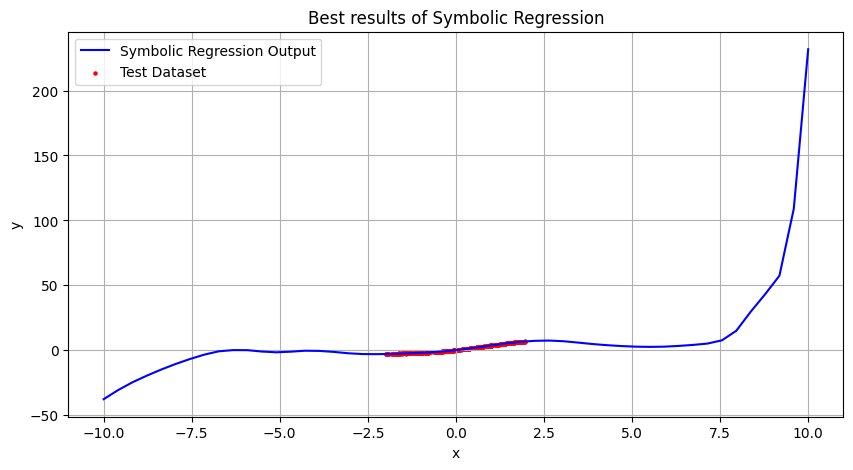

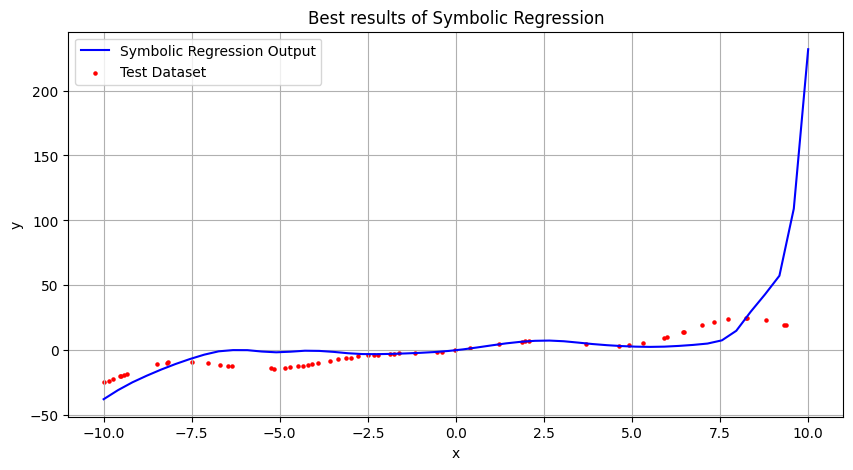

In [ ]:
activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    # *[Product()] * 2,
]


var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.


n_layers = 3                 # TODO: Number of hidden layers
reg_weight = 1e-3            # TODO: Regularization weight
learning_rate = 1e-3         # TODO: Learning rate
summary_step =  10         # TODO: Number of steps between logging summaries
epochs =  300              # TODO: Number of epochs
trials =  10                  # TODO: Number of trials. note that it should be at least 5.

best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


Running trial 1/10...
Epoch [10/300], Loss: 10.221315383911133
Epoch [20/300], Loss: 9.696011543273926
Epoch [30/300], Loss: 9.268115043640137
Epoch [40/300], Loss: 8.862332344055176
Epoch [50/300], Loss: 8.406290054321289
Epoch [60/300], Loss: 7.88575553894043
Epoch [70/300], Loss: 7.302615165710449
Epoch [80/300], Loss: 6.571969032287598
Epoch [90/300], Loss: 5.674872398376465
Epoch [100/300], Loss: 4.535175800323486
Epoch [110/300], Loss: 3.114086627960205
Epoch [120/300], Loss: 1.5352180004119873
Epoch [130/300], Loss: 0.3293050527572632
Epoch [140/300], Loss: 0.024426372721791267
Epoch [150/300], Loss: 0.018623361364006996
Epoch [160/300], Loss: 0.017420660704374313
Epoch [170/300], Loss: 0.013404649682343006
Epoch [180/300], Loss: 0.012858354486525059
Epoch [190/300], Loss: 0.012216844595968723
Epoch [200/300], Loss: 0.011832568794488907
Epoch [210/300], Loss: 0.011700253933668137
Epoch [220/300], Loss: 0.011578290723264217
Epoch [230/300], Loss: 0.01150175929069519
Epoch [240/30

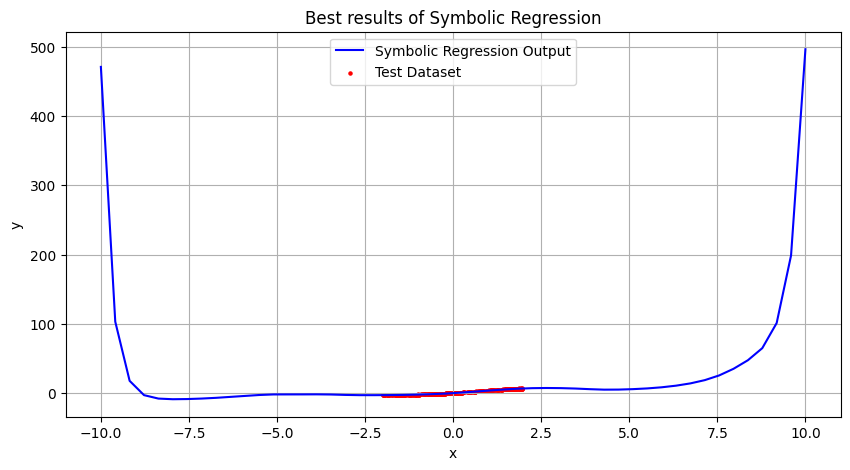

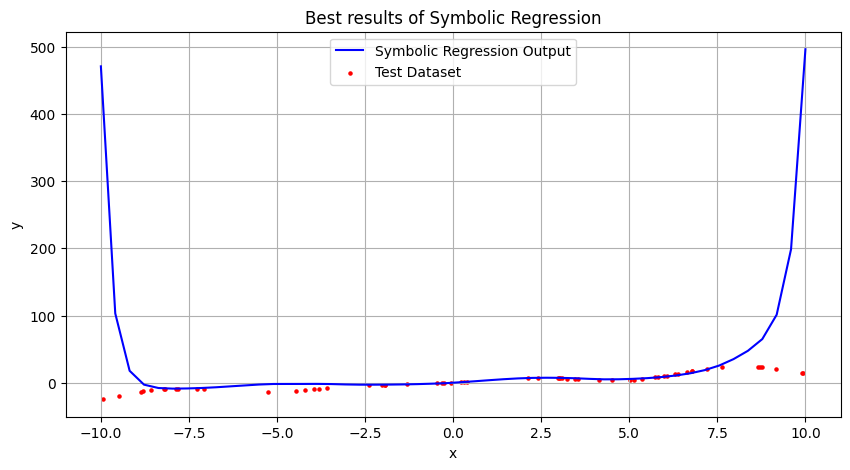

Running trial 1/10...
Epoch [10/300], Loss: 10.681488037109375
Epoch [20/300], Loss: 9.909268379211426
Epoch [30/300], Loss: 9.353189468383789
Epoch [40/300], Loss: 8.84144401550293
Epoch [50/300], Loss: 8.139784812927246
Epoch [60/300], Loss: 7.303924083709717
Epoch [70/300], Loss: 6.198101997375488
Epoch [80/300], Loss: 4.745375156402588
Epoch [90/300], Loss: 2.9876739978790283
Epoch [100/300], Loss: 1.6102538108825684
Epoch [110/300], Loss: 1.2380894422531128
Epoch [120/300], Loss: 0.9732930660247803
Epoch [130/300], Loss: 0.7356204390525818
Epoch [140/300], Loss: 0.5047817826271057
Epoch [150/300], Loss: 0.2844986319541931
Epoch [160/300], Loss: 0.11649400740861893
Epoch [170/300], Loss: 0.04102318733930588
Epoch [180/300], Loss: 0.019247738644480705
Epoch [190/300], Loss: 0.012947136536240578
Epoch [200/300], Loss: 0.011428671889007092
Epoch [210/300], Loss: 0.011107882484793663
Epoch [220/300], Loss: 0.011015099473297596
Epoch [230/300], Loss: 0.010902292095124722
Epoch [240/300]

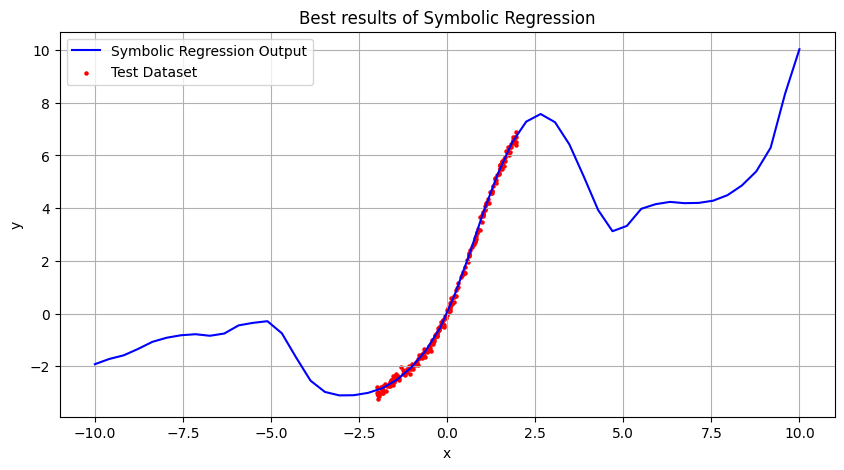

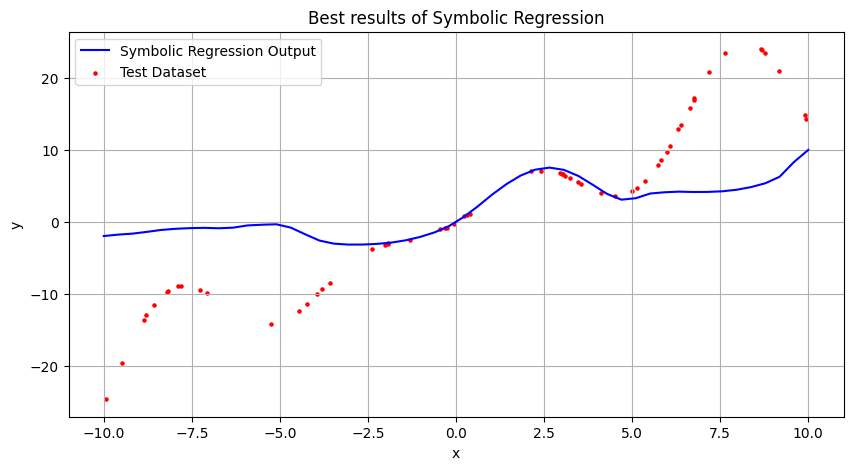

In [ ]:
# Now, change the activation functions and the number of layers (n_layers) to observe the effect on the outputs.

activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    # *[Product()] * 2,
]


var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.


n_layers = 3                 # TODO: Number of hidden layers
reg_weight = 1e-3            # TODO: Regularization weight
learning_rate = 1e-3         # TODO: Learning rate
summary_step =  10         # TODO: Number of steps between logging summaries
epochs =  300              # TODO: Number of epochs
trials =  10

for n_layers in range(3, 5):
    best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
    plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


We were previously working with the first dataset. Now, evaluate the model on the second dataset and extract the corresponding expression.

In [ ]:
x_train_ood.shape[1]

2

Running trial 1/10...
Epoch [10/300], Loss: 44843.75
Epoch [20/300], Loss: 44826.92578125
Epoch [30/300], Loss: 44808.51171875
Epoch [40/300], Loss: 44788.37890625
Epoch [50/300], Loss: 44764.1015625
Epoch [60/300], Loss: 44731.5234375
Epoch [70/300], Loss: 44680.39453125
Epoch [80/300], Loss: 44583.8828125
Epoch [90/300], Loss: 44365.64453125
Epoch [100/300], Loss: 43779.84375
Epoch [110/300], Loss: 40862.34375
Epoch [120/300], Loss: 16732.34765625
Epoch [130/300], Loss: 12406.421875
Epoch [140/300], Loss: 9271.3701171875
Epoch [150/300], Loss: 7565.16162109375
Epoch [160/300], Loss: 6105.45166015625
Epoch [170/300], Loss: 4536.93310546875
Epoch [180/300], Loss: 3197.99853515625
Epoch [190/300], Loss: 2076.02001953125
Epoch [200/300], Loss: 1322.8092041015625
Epoch [210/300], Loss: 951.0516357421875
Epoch [220/300], Loss: 769.8177490234375
Epoch [230/300], Loss: 666.0283203125
Epoch [240/300], Loss: 596.2260131835938
Epoch [250/300], Loss: 541.2747192382812
Epoch [260/300], Loss: 494.

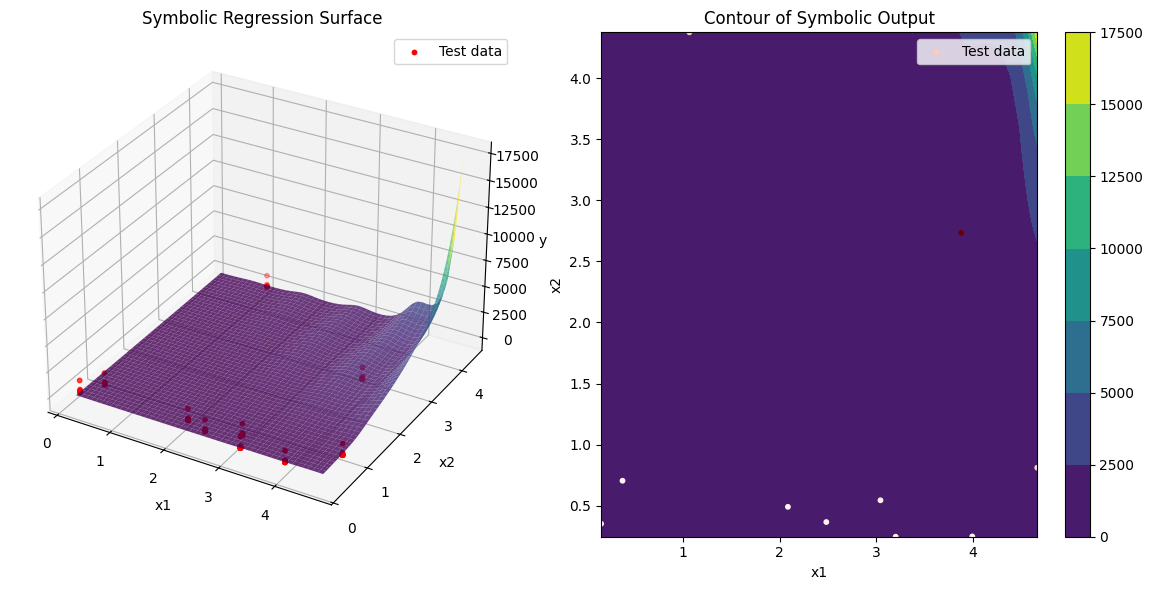

In [ ]:
# TODO: Find expression for second dataset.

activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    # *[Product()] * 2,
]


var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.


n_layers = 3                 # TODO: Number of hidden layers
reg_weight = 1e-3            # TODO: Regularization weight
learning_rate = 1e-3         # TODO: Learning rate
summary_step =  10         # TODO: Number of steps between logging summaries
epochs =  300              # TODO: Number of epochs
trials =  10


best_expr = run(x_train_ood, x_test_ood, y_train_ood, y_test_ood, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
plot_symbolic_3d(x_test_ood, y_test_ood, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))

# ============================================================================


### Bonus

We know that in the first and second dataset, the expression is simple and contains only one or at most two terms. However, as you can see, the expressions here are quite long. Now, think about what adjustments you can make to simplify them and reduce their length.


🔁 Trial 1/10
Epoch [100/1000], Loss: 5.455758571624756
Epoch [200/1000], Loss: 0.06559252738952637
Epoch [300/1000], Loss: 0.012839625589549541
Epoch [400/1000], Loss: 0.01229130383580923
Epoch [500/1000], Loss: 0.011865640059113503
Epoch [600/1000], Loss: 0.011420776136219501
Epoch [700/1000], Loss: 0.010809492319822311
Epoch [800/1000], Loss: 0.010556420311331749
Epoch [900/1000], Loss: 0.010437941178679466
Epoch [1000/1000], Loss: 0.010367212817072868
Test Loss: 646.9470, Complexity: 142, Total Score: 647.6570
Expression: 0.0824681*x_1**2 + 0.29656*x_1 + 0.070111*(-0.214355*x_1**2 - 0.876505*x_1 - 0.34655611690037*exp(0.240764*x_1) - 0.607166*sin(0.785387489947142*x_1) - sin(0.999715427943194*x_1) - 0.962120487634959 + 0.389056918173771*exp(-0.269253*x_1) - 0.918931/(1 + exp(-2.29194*x_1)) - 0.738896/(1 + exp(-2.5525*x_1)))**2 - 0.122871493324143*(-0.0652292995229519*x_1**2 + 0.567815504834932*x_1 + 0.0974026477742143*exp(0.240764*x_1) + 0.293981251014016*sin(0.785387489947142*x_1)

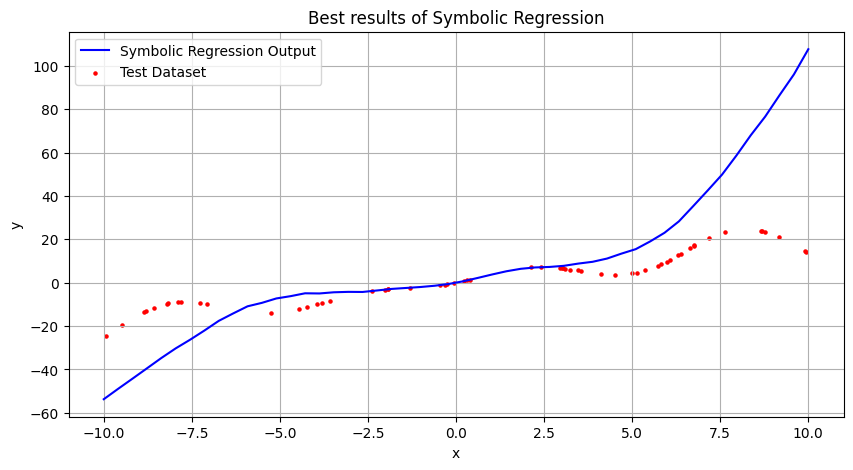

In [ ]:
# TODO
import sympy as sp

def compute_complexity(expr):
    """Compute expression complexity by number of operators/length."""
    try:
        simplified_expr = sp.sympify(expr.replace("^", "**"))
        return len(simplified_expr.atoms(sp.Function, sp.Symbol, sp.Add, sp.Mul, sp.Pow))
    except Exception as e:
        print(e)
        return len(expr)  # fallback: use string length

def simplify_expression(expr_str):
    try:
        # expr = sp.sympify(expr_str.replace("^", "**"))
        # return str(sp.simplify(expr))
        expr = sp.expand(expr)        # Expand expressions like (a + b)^2
        expr = sp.cancel(expr)        # Cancel common terms in fractions
        expr = sp.powsimp(expr)       # Combine powers: x**a * x**b -> x**(a+b)
        expr = sp.trigsimp(expr)
    except Exception:
        return expr_str

def run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials=10, lambda_complexity=0.001, simplify=True):
    test_losses = []
    expressions = []
    penalties = []
    total_losses = []

    for trial in range(trials):
        print(f"\n🔁 Trial {trial + 1}/{trials}")

        net = train(x_train, y_train, activation_funcs, in_dim=x_train.shape[1], n_layers=n_layers,
                    learning_rate=learning_rate, summary_step=summary_step, epochs=epochs)

        test_loss = test(net, x_test, y_test)
        expr = str(find_expression(net, x_train.shape[1]))
        complexity = compute_complexity(expr)
        total_loss = test_loss + lambda_complexity * complexity

        print(f"Test Loss: {test_loss:.4f}, Complexity: {complexity}, Total Score: {total_loss:.4f}")
        print(f"Expression: {expr}")

        test_losses.append(test_loss)
        penalties.append(complexity)
        total_losses.append(total_loss)
        expressions.append(expr)

    best_index = np.argmin(total_losses)
    best_expr = expressions[best_index]

    print(best_expr)
    best_expr_simplified = simplify_expression(best_expr) if simplify else best_expr
    print(best_expr_simplified)

    print(f"\n✅ Best Trial: {best_index + 1}")
    print(f"Raw Test Loss: {test_losses[best_index]:.4f}, Complexity: {penalties[best_index]}, Final Score: {total_losses[best_index]:.4f}")
    print("Best Symbolic Expression:", best_expr_simplified)

    return best_expr_simplified

best_expr = ""
best_expr = run(
    x_train, x_test, y_train, y_test,
    activation_funcs=activation_funcs,
    n_layers=2,
    learning_rate=1e-3,
    summary_step=100,
    epochs=1000,
    trials=10,
    lambda_complexity=0.005,  # adjust to make it stricter
    simplify=True
)

plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))

In [ ]:
best = "0.0824681*x_1**2 + 0.29656*x_1 + 0.070111*(-0.214355*x_1**2 - 0.876505*x_1 - 0.34655611690037*exp(0.240764*x_1) - 0.607166*sin(0.785387489947142*x_1) - sin(0.999715427943194*x_1) - 0.962120487634959 + 0.389056918173771*exp(-0.269253*x_1) - 0.918931/(1 + exp(-2.29194*x_1)) - 0.738896/(1 + exp(-2.5525*x_1)))**2 - 0.122871493324143*(-0.0652292995229519*x_1**2 + 0.567815504834932*x_1 + 0.0974026477742143*exp(0.240764*x_1) + 0.293981251014016*sin(0.785387489947142*x_1) + 0.278681819391868*sin(0.999715427943194*x_1) - 1 - 0.0397426218583919*exp(-0.269253*x_1) - 0.350659175693074/(1 + exp(-2.29194*x_1)) - 0.257440871260581/(1 + exp(-2.5525*x_1)))**2 - 0.0674841952278379*(0.0529897587162893*x_1**2 - 0.359405451320713*x_1 - 0.268320763556965*exp(0.240764*x_1) - 0.231930393418314*sin(0.785387489947142*x_1) - 0.655473492575673*sin(0.999715427943194*x_1) + 1 + 0.175616584518927*exp(-0.269253*x_1) + 0.346495078975391/(1 + exp(-2.29194*x_1)) + 0.522166850607966/(1 + exp(-2.5525*x_1)))**2 - 0.124603007314289*(0.0619513148874403*x_1**2 - 0.595678297969987*x_1 - 0.0984219014190278*exp(0.240764*x_1) - 0.336052693880724*sin(0.785387489947142*x_1) - 0.29096753950062*sin(0.999715427943194*x_1) + 1 + 0.0859167311579429*exp(-0.269253*x_1) + 0.463961810515366/(1 + exp(-2.29194*x_1)) + 0.165137823072756/(1 + exp(-2.5525*x_1)))**2 + 0.0796330978341504*exp(0.240764*x_1) - 0.0715454761562888*exp(-0.0689606*x_1**2 - 0.157964*x_1 - 0.0307085175039421*exp(0.240764*x_1) - 0.166985*sin(0.785387489947142*x_1) - 0.280636*sin(0.999715427943194*x_1) + 0.0787601883320864*exp(-0.269253*x_1) - 0.121038/(1 + exp(-2.29194*x_1)) + 0.0955475/(1 + exp(-2.5525*x_1))) - 0.0851041876029715*exp(-0.0215546*x_1**2 - 0.334774*x_1 - 0.104284278011572*exp(0.240764*x_1) - 0.064583*sin(0.785387489947142*x_1) - 0.105944*sin(0.999715427943194*x_1) + 0.0816393281234389*exp(-0.269253*x_1) - 0.190997/(1 + exp(-2.29194*x_1)) - 0.331333/(1 + exp(-2.5525*x_1))) + 0.128553*sin(0.785387489947142*x_1) + 0.180767*sin(0.999715427943194*x_1) - 0.243315*sin(-0.755000598245418*x_1**2 + 0.271074272817244*x_1 - 0.199335636344644*exp(0.240764*x_1) + 0.249035166182847*sin(0.785387489947142*x_1) - 0.585397506715885*sin(0.999715427943194*x_1) + 0.829560918462616 + 0.252402864098533*exp(-0.269253*x_1) + 2.50427101136239/(1 + exp(-2.29194*x_1)) - 2.68356905996008/(1 + exp(-2.5525*x_1))) + 0.258586*sin(0.299070662750688*x_1**2 - 0.108561547304201*x_1 + 0.124549804095106*exp(0.240764*x_1) + 1.02029018869028*sin(0.785387489947142*x_1) - 1.17331235604919*sin(0.999715427943194*x_1) - 1.17373949780227 - 0.745253991229324*exp(-0.269253*x_1) + 0.806835039323662/(1 + exp(-2.29194*x_1)) + 1.2151433867081/(1 + exp(-2.5525*x_1))) + 1.10299058703892 - 0.121206782750741*exp(-0.269253*x_1) - 0.274888/(0.0547996584603452*exp(-0.0337725*x_1**2 + 3.37666*x_1 + 1.64762927732243*exp(0.240764*x_1) + 2.11582*sin(0.785387489947142*x_1) - 0.242774*sin(0.999715427943194*x_1) - 1.12105074525319*exp(-0.269253*x_1) - 2.38245/(1 + exp(-2.29194*x_1)) - 1.28821/(1 + exp(-2.5525*x_1))) + 1) - 0.30364/(0.828552416757761*exp(-0.999714*x_1**2 + 2.9427*x_1 - 0.703586247304707*exp(0.240764*x_1) - 0.762953*sin(0.785387489947142*x_1) + 2.53213*sin(0.999715427943194*x_1) - 0.684601735150222*exp(-0.269253*x_1) - 0.23961/(1 + exp(-2.5525*x_1))) + 1) + 0.288646/(1 + exp(-2.29194*x_1)) + 0.23585/(1 + exp(-2.5525*x_1))"
prev = "0.0261164*x_1**2 + 0.0714794*x_1 + 0.0182073523253133*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.00249739*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 - 0.0863355635149193*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.018876*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 - 0.031755*(0.00313566*x_1**2 + 0.0100857*x_1 - 0.00534705334970538*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 + 0.015177*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.0615337927391229*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.0222479*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.0195088917521037*exp(0.155051*x_1) - 0.0403741216763836*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.293635859578949*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.0714144*sin(0.63300657224742*x_1) + 0.0509067*sin(0.824471792433793*x_1) - 0.740806*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 0.792182*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 0.549763148684743 - 0.00360663966050365*exp(-0.149015*x_1) + 1/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.109098/(exp(1.71036*x_1) + 1) + 0.0539963/(1 + exp(-1.34432*x_1)))**2 + 0.237996301789852*(-0.0209949882735536*x_1**2 - 0.0534292292414135*x_1 - 0.0232245511233289*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.00790417628418912*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.0724270410801313*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 - 0.0548790745725484*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 - 0.0638219538032322*exp(0.155051*x_1) + 0.0551421986561679*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.174841255912093*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.0862808663584949*sin(0.63300657224742*x_1) - 0.173024933204438*sin(0.824471792433793*x_1) - 0.294960008533689*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 0.0653474740105951*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) - 1 + 0.0497439537042783*exp(-0.149015*x_1) - 0.235170372617771/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) - 0.114175440838693/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) - 0.0117021122015501/(exp(1.71036*x_1) + 1) - 0.0775227406040905/(1 + exp(-1.34432*x_1)))**2 - 0.0208983*(-0.00305198*x_1**2 - 0.0594756*x_1 - 0.0358148866545081*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 + 0.021577*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.227812883502556*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.197135*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 - 0.0190985762487449*exp(0.155051*x_1) - 0.253560344260716*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.39096242611188*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.317006*sin(0.63300657224742*x_1) - 0.127423*sin(0.824471792433793*x_1) - 0.893459*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 0.0421744*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 0.660577113942253 + 0.0775589587183374*exp(-0.149015*x_1) - 0.374464/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 1/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.143397/(exp(1.71036*x_1) + 1) + 0.0553058/(1 + exp(-1.34432*x_1)))**2 - 0.0428668255383197*(-0.00106409457153926*x_1**2 - 0.000973657922037029*x_1 - 0.0355856342546582*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.00276377174630953*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.0826993021070222*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.0711427265155175*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 - 0.00246783988565468*exp(0.155051*x_1) + 0.0157404741586831*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.182578869390442*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.125151137222388*sin(0.63300657224742*x_1) + 0.0054068438107314*sin(0.824471792433793*x_1) - 0.0649922727132587*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 0.760460507319155*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 1 + 0.0198190918781612*exp(-0.149015*x_1) - 0.276291864839972/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 0.287598228452652/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.0734715914963782/(exp(1.71036*x_1) + 1) + 0.0412284536321999/(1 + exp(-1.34432*x_1)))**2 + 0.0789602462314973*exp(0.155051*x_1) - 0.0494238731961709*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) - 0.0669129624431203*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) + 0.190671661267963*exp(0.0205478*x_1**2 + 0.0563198*x_1 + 0.0219189226432401*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 + 0.00702172*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 - 0.0680444696035771*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.00694859*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.0643691841041448*exp(0.155051*x_1) - 0.0214173241959687*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) - 0.167423006047514*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) + 0.119796*sin(0.63300657224742*x_1) + 0.178007*sin(0.824471792433793*x_1) - 0.0263599*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) + 0.237377*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) - 0.056907064737754*exp(-0.149015*x_1) + 0.317867/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 0.347671/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.000152875/(exp(1.71036*x_1) + 1) + 0.0677703/(1 + exp(-1.34432*x_1))) + 0.195297444793177*exp(0.0233654*x_1**2 + 0.0602701*x_1 + 0.0269585086582936*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.000948395*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 - 0.0625461615387379*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.0235748*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.0742549409459037*exp(0.155051*x_1) - 0.0200765245921501*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) - 0.0631338091211037*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) + 0.137182*sin(0.63300657224742*x_1) + 0.19565*sin(0.824471792433793*x_1) + 0.230262*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) + 0.210375*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) - 0.0646236630414361*exp(-0.149015*x_1) + 0.142311/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 0.242391/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.00780893/(exp(1.71036*x_1) + 1) + 0.0755682/(1 + exp(-1.34432*x_1))) + 0.118522*sin(0.63300657224742*x_1) + 0.224636*sin(0.824471792433793*x_1) + 0.181013*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) + 0.244427*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 0.167627*sin(0.0530979458682899*x_1**2 + 0.00663384194900193*x_1 - 0.080764164472077*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.0761016655741218*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.166854676149911*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 - 0.192239057036926*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.193634008093166*exp(0.155051*x_1) - 0.262903868084434*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 1.08961293433214*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.210619358741698*sin(0.63300657224742*x_1) + 0.23745014236296*sin(0.824471792433793*x_1) - 0.707864722344131*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) + 2.11765223987375 - 0.0490317999236543*exp(-0.149015*x_1) - 0.465251298395482/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.535672523287877/(exp(1.71036*x_1) + 1) + 0.306199638101126/(1 + exp(-1.34432*x_1))) + 0.194529*sin(0.00823682419393237*x_1**2 - 0.160196188882851*x_1 - 0.0364721676198873*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 - 0.0379907156315115*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.15121271337868*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 - 0.0798964107033453*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.0271111254054705*exp(0.155051*x_1) + 0.163831607256007*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) - 0.371171996392071*sin(0.63300657224742*x_1) - 0.290486072208034*sin(0.824471792433793*x_1) + 1.69123142047425*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) + 1.09370732936888*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 0.988881226968793 + 0.0948734535292608*exp(-0.149015*x_1) - 0.248449226530394/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) - 1.57038174751458/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.344144760427779/(exp(1.71036*x_1) + 1) + 0.0666924866269082/(1 + exp(-1.34432*x_1))) + 0.751228228288866 - 0.0647276114114127*exp(-0.149015*x_1) + 0.215035/(6.65338950593889*exp(0.209051*x_1**2 + 0.540395*x_1 - 0.171803979094381*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 + 0.0688825*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 + 0.340038177170818*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 + 0.296217*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 + 0.663605436314535*exp(0.155051*x_1) - 0.927893072159732*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.523283501767407*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) + 0.420058*sin(0.63300657224742*x_1) + 1.81439*sin(0.824471792433793*x_1) - 2.52151*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 1.66747*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) - 0.454468088720277*exp(-0.149015*x_1) - 4.57724/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 1.59892/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.53523/(exp(1.71036*x_1) + 1) + 0.965113/(1 + exp(-1.34432*x_1))) + 1) + 0.143547/(0.0600195339939944*exp(-0.154057*x_1**2 - 0.473439*x_1 - 0.280260742044148*(0.0575667784125674*x_1**2 + 0.288674368594974*x_1 + 0.184504666454907*exp(0.155051*x_1) + 0.282436030920379*sin(0.63300657224742*x_1) + 0.961308411435589*sin(0.824471792433793*x_1) + 1 + 0.280597763336662/(exp(1.71036*x_1) + 1) + 0.559697188882582/(1 + exp(-1.34432*x_1)))**2 + 0.0601755*(-0.144159*x_1**2 - 0.152035*x_1 + 0.25926406929909*exp(0.155051*x_1) + 0.347774*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) - 0.506293887310174 - 0.424973397299675*exp(-0.149015*x_1) - 0.502659/(exp(1.71036*x_1) + 1) + 0.942102/(1 + exp(-1.34432*x_1)))**2 - 0.379728874434585*(-0.0696692628014978*x_1**2 + 0.112368194462832*x_1 + 0.175796600085378*exp(0.155051*x_1) + 0.310828205173728*sin(0.63300657224742*x_1) + 0.769876559604231*sin(0.824471792433793*x_1) - 1 - 0.114726137701851*exp(-0.149015*x_1) - 0.314977991319268/(exp(1.71036*x_1) + 1) - 0.145848052838417/(1 + exp(-1.34432*x_1)))**2 - 0.137376*(0.0136583*x_1**2 + 0.105342*x_1 + 0.117100258646491*exp(0.155051*x_1) + 0.336967*sin(0.63300657224742*x_1) + sin(0.824471792433793*x_1) + 0.437793164146405 - 0.074501141026588*exp(-0.149015*x_1) - 0.187836/(exp(1.71036*x_1) + 1) + 0.0617673/(1 + exp(-1.34432*x_1)))**2 - 0.382758819499377*exp(0.155051*x_1) + 0.275976953230697*exp(-0.0133212*x_1**2 - 0.0619915*x_1 - 0.034502056831611*exp(0.155051*x_1) - 0.0996771*sin(0.824471792433793*x_1) + 0.120486903535864*exp(-0.149015*x_1) - 0.139543/(exp(1.71036*x_1) + 1) - 0.284576/(1 + exp(-1.34432*x_1))) + 0.777384777742288*exp(-0.0173693*x_1**2 - 0.0619456*x_1 - 0.126891929522582*exp(0.155051*x_1) - 0.271159*sin(0.63300657224742*x_1) - 0.206379*sin(0.824471792433793*x_1) + 0.0562450153075627*exp(-0.149015*x_1) + 0.1763/(exp(1.71036*x_1) + 1) - 0.14162/(1 + exp(-1.34432*x_1))) - 0.977561*sin(0.63300657224742*x_1) - 1.29948*sin(0.824471792433793*x_1) - 0.731012*sin(-0.0706632734661184*x_1**2 + 0.141765609609531*x_1 - 0.821908513481887*exp(0.155051*x_1) - 2.45292928109324*sin(0.63300657224742*x_1) + 2.11134273136235*sin(0.824471792433793*x_1) + 3.02391211645471 + 0.48976472661118*exp(-0.149015*x_1) + 2.30945076996306/(exp(1.71036*x_1) + 1) - 0.130822490836138/(1 + exp(-1.34432*x_1))) - 2.17848*sin(0.13656961717559*x_1**2 - 0.116481387871636*x_1 + 0.35096408603063*exp(0.155051*x_1) + 1.34776802877107*sin(0.63300657224742*x_1) + 1.09737899627426*sin(0.824471792433793*x_1) - 1.21550805580421 + 0.0943023866913971*exp(-0.149015*x_1) + 0.499745174609595/(exp(1.71036*x_1) + 1) - 0.620430204916955/(1 + exp(-1.34432*x_1))) + 0.369696404986874*exp(-0.149015*x_1) - 2.02231/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 2.6267/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.664222/(exp(1.71036*x_1) + 1) - 0.40159/(1 + exp(-1.34432*x_1))) + 1) + 0.204812/(4.89412064272916*exp(0.285196*x_1**2 - 1.49738*x_1 + 0.646454222428684*exp(0.155051*x_1) - 2.69289*sin(0.63300657224742*x_1) - 2.59975*sin(0.824471792433793*x_1) + 1.16563875140706*exp(-0.149015*x_1) - 0.534245/(exp(1.71036*x_1) + 1) + 1.78747/(1 + exp(-1.34432*x_1))) + 1) + 0.0124503/(0.00588705845679891*exp(-0.0894398*x_1**2 - 0.483924*x_1 - 0.299960686162428*exp(0.155051*x_1) - 1.59109*sin(0.824471792433793*x_1) - 0.283023144466686*exp(-0.149015*x_1) - 1.63978/(exp(1.71036*x_1) + 1) - 1.10631/(1 + exp(-1.34432*x_1))) + 1) + 0.0029513/(exp(1.71036*x_1) + 1) + 0.0950278/(1 + exp(-1.34432*x_1))"
compute_complexity(best), compute_complexity(prev)

(142, 348)

# Seq2Seq-Based Symbolic Regression with Transformers

<p align="center">
  <img style="margin-top: 30px" src="https://cdn.botpenguin.com/assets/website/Sequence_to_Sequence_Models_0b5fb158a1.webp" width="500">
</p>

Symbolic regression is a method that aims to find a mathematical expression that best fits a given dataset. Unlike traditional regression techniques, symbolic regression does not assume a predefined function structure; instead, it searches for an optimal mathematical expression that relates input features to target variables. One effective approach to symbolic regression is using sequence-to-sequence (Seq2Seq) models based on transformers.

### Overview of Seq2Seq Models in Symbolic Regression:
A Seq2Seq model consists of an encoder and a decoder, both of which are typically built using transformer architectures. The main idea is to treat symbolic regression as a sequence translation problem, where:
- The input is a set of numerical data points (features).
- The output is a mathematical expression represented as a sequence of tokens.
- This approach allows the model to learn a mapping from numerical inputs to symbolic expressions, making it a powerful tool for symbolic regression.

### Encoder: Processing the Input Data

The encoder in a Seq2Seq transformer is responsible for encoding the full dataset into a latent representation. Here’s how it works:

1. Tokenization: The input dataset (typically a set of feature-value pairs) is transformed into a sequence of tokens. Each token can represent a numerical value or a special marker that indicates structural information.

2. Embedding Layer: The numerical tokens are converted into dense vector representations using an embedding layer.

3. Positional Encoding: Since transformers do not have built-in recurrence mechanisms, positional encodings are added to the embeddings to retain the order of the input sequence.

4. Self-Attention Mechanism: The encoder consists of multiple self-attention layers that allow the model to weigh the importance of different parts of the input sequence dynamically.

5. Output Representation: The encoder outputs a context-aware representation of the input sequence, which is then passed to the decoder.

### Decoder: Generating the Mathematical Expression
The decoder takes the encoder’s output and generates the target sequence, which is a symbolic mathematical expression. This process follows these steps:

1. Input Token Embedding: The decoder receives an initial input token (typically a start-of-sequence token <SOS>).

2. Self-Attention Layers: The decoder generates tokens one by one, attending to previously generated tokens using masked self-attention.

3. Cross-Attention with Encoder Outputs: The decoder also attends to the encoder’s output using cross-attention layers, ensuring that the generated expression is conditioned on the input data.

4. Token Generation via Softmax: The final layer applies a softmax function over the vocabulary (consisting of mathematical symbols, operators, and variables) to predict the next token.


In this section, we will implement symbolic regression using transformers. First, we generate the dataset and save it in the `data` folder. Do not modify the cell below. We suggest reading and understanding it first.

In [54]:
# Don't change this cell.

C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)

MY_VOCAB = np.array([
    ['add', 4, 2],  # binary operators
    ['sub', 3, 2],
    ['mul', 6, 2],
    ['sin', 1, 1],  # unary operators
    ['cos', 1, 1],
    ['log', 2, 1],
    ['exp', 2, 1],
    ['neg', 0, 1],
    ['inv', 3, 1],
    ['sq', 2, 1],
    ['cb', 0, 1],
    ['sqrt', 2, 1],
    ['cbrt', 0, 1],
    ['C', 8, 0],  # leaves
    ['x1', 8, 0],
    ['x2', 8, 0],
    ['x3', 4, 0],
    ['x4', 4, 0],
    ['x5', 2, 0],
    ['x6', 2, 0],
])


def generate_expression(vocab):
    """
    Recursive function!
    Generate one expression using the tokens and their
    respective probabiities provided by 'vocab'.
    """
    weights = vocab[:, 1].astype('float32')
    probs = weights / np.sum(weights)
    N = len(vocab)
    expr = []
    rand_idx = np.random.choice(N, p=probs)
    cur_token = vocab[rand_idx, 0]
    cur_arity = int(vocab[rand_idx, 2])
    expr.append(cur_token)
    if cur_arity==0:
        return expr
    else:
        if cur_token in ['sin', 'cos']:
            idx1 = np.where(vocab[:, 0]=='sin')[0][0]
            idx2 = np.where(vocab[:, 0]=='cos')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        elif cur_token in ['log', 'exp']:
            idx1 = np.where(vocab[:, 0]=='log')[0][0]
            idx2 = np.where(vocab[:, 0]=='exp')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        else:
            new_vocab = vocab
        if cur_arity==1:
            child = generate_expression(new_vocab)
            return expr + child
        elif cur_arity==2:
            child1 = generate_expression(new_vocab)
            child2 = generate_expression(new_vocab)
            return expr + child1 + child2


def translate_integers_into_tokens(seq_int):
    seq_tokens = []
    for n in range(len(seq_int)):
        if seq_int[n]>=2:
            seq_tokens.append(MY_VOCAB[seq_int[n]-2])
    return seq_tokens


def from_sequence_to_sympy(expr):
    """
    Recursive function!
    Convert the initial sequence of tokens into SymPy expression.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])


    cur_token = expr[0]
    try:
        return float(cur_token)  # for cases when constants are evaluated
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        if cur_token=='C':
            return C
        elif cur_token=='x1':
            return x1
        elif cur_token=='x2':
            return x2
        elif cur_token=='x3':
            return x3
        elif cur_token=='x4':
            return x4
        elif cur_token=='x5':
            return x5
        elif cur_token=='x6':
            return x6
    elif cur_arity==1:
        if cur_token=='sin':
            return sympy.sin(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cos':
            return sympy.cos(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='log':
            return sympy.log(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='exp':
            return sympy.exp(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='neg':
            return - from_sequence_to_sympy(expr[1:])
        elif cur_token=='inv':
            return 1 / from_sequence_to_sympy(expr[1:])
        elif cur_token=='sq':
            return (from_sequence_to_sympy(expr[1:]))**2
        elif cur_token=='cb':
            return (from_sequence_to_sympy(expr[1:]))**3
        elif cur_token=='sqrt':
            return sympy.sqrt(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cbrt':
            return sympy.cbrt(from_sequence_to_sympy(expr[1:]))
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return from_sequence_to_sympy(left_list) + from_sequence_to_sympy(right_list)
        elif cur_token=='sub':
            return from_sequence_to_sympy(left_list) - from_sequence_to_sympy(right_list)
        elif cur_token=='mul':
            return from_sequence_to_sympy(left_list) * from_sequence_to_sympy(right_list)


def from_sequence_to_string(expr):
    """
    OBSOLETE
    Recursive function!
    Convert the initial sequence of tokens into a string
    which can be read by SymPy.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])

    cur_token = expr[0]
    try:
        float(cur_token)  # for cases when constants are evaluated
        cur_arity = 0
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        return cur_token
    elif cur_arity==1:
        if cur_token=='inv':
            return '1/(' + from_sequence_to_string(expr[1:]) + ')'
        elif cur_token=='sq':
            return '(' + from_sequence_to_string(expr[1:]) + ')**2'
        elif cur_token=='cb':
            return '(' + from_sequence_to_string(expr[1:]) + ')**3'
        elif cur_token=='neg':
            return '-(' + from_sequence_to_string(expr[1:]) + ')'
        else:
            return cur_token + '(' + from_sequence_to_string(expr[1:]) + ')'
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return '(' + from_sequence_to_string(left_list) + ')+(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='sub':
            return '(' + from_sequence_to_string(left_list) + ')-(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='mul':
            return '(' + from_sequence_to_string(left_list) + ')*(' + from_sequence_to_string(right_list) + ')'


def expression_tree_depth(sympy_expr):
    """
    Recursive function!
    Count the maximum depth for a given SymPy expression.
    """
    if len(sympy_expr.args)==0:
        return 1
    elif len(sympy_expr.args)==1:
        return 1 + expression_tree_depth(sympy_expr.args[0])
    else:
        max_depth = 0
        for a in sympy_expr.args:
            temp_depth = expression_tree_depth(a)
            if temp_depth > max_depth:
                max_depth = temp_depth
        return 1 + max_depth


def first_variables_first(sympy_expr):
    """
    Counts the number of variables in the SymPy expression,
    and assign firte variables first.
    Example: log(x3)+x5 becomes log(x1)+x2
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    sympy_str = str(sympy_expr)
    exist = []
    for t in tokens:
        exist.append(t in sympy_str)
    for idx_new, idx_old in enumerate(np.where(exist)[0]):
        sympy_str = sympy_str.replace(f'x{idx_old+1}', f'x{idx_new+1}')
    sympy_expr = sympy.sympify(sympy_str)
    return sympy_expr


def from_sympy_to_sequence(sympy_expr):
    """
    Recursive function!
    Convert a SymPy expression into a standardized sequence of tokens,
    which will be used as the ground truth to train the ST.
    This function calls from_sympy_power_to_sequence,
    from_sympy_multiplication_to_sequence, and
    from_sympy_addition_to sequence.
    """
    if len(sympy_expr.args)==0:  # leaf
        return [str(sympy_expr)]
    elif len(sympy_expr.args)==1:  # unary operator
        return [str(sympy_expr.func)] + from_sympy_to_sequence(sympy_expr.args[0])
    elif len(sympy_expr.args)>=2:  # binary operator
        if sympy_expr.func==sympy.core.power.Pow:
            power_seq = from_sympy_power_to_sequence(sympy_expr.args[1])
            return power_seq + from_sympy_to_sequence(sympy_expr.args[0])
        elif sympy_expr.func==sympy.core.mul.Mul:
            return from_sympy_multiplication_to_sequence(sympy_expr)
        elif sympy_expr.func==sympy.core.add.Add:
            return from_sympy_addition_to_sequence(sympy_expr)


def from_sympy_power_to_sequence(exponent):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for power functions.
    """
    if exponent==(-4):
        return ['inv', 'sq', 'sq']
    elif exponent==(-3):
        return ['inv', 'cb']
    elif exponent==(-2):
        return ['inv', 'sq']
    elif exponent==(-3/2):
        return ['inv', 'cb', 'sqrt']
    elif exponent==(-1):
        return ['inv']
    elif exponent==(-1/2):
        return ['inv', 'sqrt']
    elif exponent==(-1/3):
        return ['inv', 'cbrt']
    elif exponent==(-1/4):
        return ['inv', 'sqrt', 'sqrt']
    elif exponent==(1/4):
        return ['sqrt', 'sqrt']
    elif exponent==(1/3):
        return ['cbrt']
    elif exponent==(1/2):
        return ['sqrt']
    elif exponent==(3/2):
        return ['cb', 'sqrt']
    elif exponent==(2):
        return ['sq']
    elif exponent==(3):
        return ['cb']
    elif exponent==(4):
        return ['sq', 'sq']
    else:
        return ['abort']


def from_sympy_multiplication_to_sequence(sympy_mul_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for multiplications.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_factors = 0
    nb_constants = 0
    is_neg = False
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if cur_fact==(-1):
            is_neg = True
        if any(t in str(cur_fact) for t in tokens):
            nb_factors += 1
        else:
            nb_constants += 1
    seq = []
    if is_neg:
        seq.append('neg')
    for _ in range(nb_factors-1):
        seq.append('mul')
    if nb_constants>0:
        seq.append('mul')
        seq.append('C')
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if any(t in str(cur_fact) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_fact)
    return seq


def from_sympy_addition_to_sequence(sympy_add_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for additions.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_terms = 0
    nb_constants = 0
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            nb_terms += 1
        else:
            nb_constants += 1
    seq = []
    for _ in range(nb_terms-1):
        seq.append('add')
    if nb_constants>0:
        seq.append('add')
        seq.append('C')
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_term)
    return seq


def sample_from_sympy_expression(sympy_expr, nb_samples=200):
    """
    Sample from SymPy expression.
    Variables are first sampled using log-uniform distributions.
    """
    np_x = np.power(10.0, np.random.uniform(low=-1.0, high=1.0, size=(nb_samples, 6)))
    f = sympy.lambdify([x1, x2, x3, x4, x5, x6], sympy_expr)
    np_y = f(np_x[:, 0], np_x[:, 1], np_x[:, 2], np_x[:, 3], np_x[:, 4], np_x[:, 5])
    return np_y, np_x


def count_nb_variables_sympy_expr(sympy_expr):
    """
    Assumes that the variables are properly numbered, i.e.
    first_variables_first has been applied.
    Returns the number of variables in the SymPy expression.
    """
    nb_variables = 0
    while f'x{nb_variables+1}' in str(sympy_expr):
        nb_variables += 1
    return nb_variables

def is_tree_complete(seq_indices):
    """
    Check whether a given sequence of tokens defines
    a complete symbolic expression.
    """
    arity = 1
    for n in seq_indices:
        if n in [0, 1]:
            continue
            print('Predict padding or <SOS>, which is bad...')
        cur_token = MY_VOCAB[n-2]  # vocabulary is hard-coded, token 0 for padding, token 1 is <SOS>
        if cur_token in ['add', 'mul']:
            arity = arity + 2 - 1
        elif cur_token in ['sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb']:
            arity = arity + 1 - 1
        elif cur_token in ['C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']:
            arity = arity + 0 - 1
    if arity==0:
        return True
    else:
        return False

In [55]:
# Don't change this cell.

# Number of initial trials
NB_TRAILS = 10000
# Minimum number of nodes (for the first crude filtering)
NB_NODES_MIN = 2
# Maximum number of nodes (for the first crude filtering)
NB_NODES_MAX = 15
# Maximum number of seconds to wait when SymPy tries to simplify
MAX_SEC_WAIT_SIMPLIFY = 5
# Minimum number of nodes (for the first crude filtering)
NB_NESTED_MAX = 6
# Minimum number of constants in the final sequences
NB_CONSTANTS_MIN = 1
# Maximum number of constants in the final sequences
NB_CONSTANTS_MAX = 1
# Maximum number of variables
NB_VARIABLES_MAX = 6
# Maximum sequence length possible (otherwise discard)
SEQ_LENGTH_MAX = 30
# Number of times we evaluate constants for each unique equation  -- BEFORE 100
NB_SAMPLING_PER_EQ = 25
# When sampling, if at least one point is above this magnitude, abort  -- BEFORE 1.0e12
ORDER_OF_MAG_LIMIT = 1.0e+9
# Number of sample points for the datasets  -- BEFORE 200
NB_SAMPLE_PTS = 50
# Variable representation: 'normal' is (y, x1, x2, ...), 'log' is log(abs(y, x1, x2, ...)), or 'both'
VARIABLE_TYPE = 'normal'
# Path output
PATH_OUT = 'data'
# Number zfill zeros
NB_ZFILL = 8

In [ ]:
print('Generate a lot of expression trees...')
all_my_expr = []
percent = 0
for n in range(NB_TRAILS):
    if int((n+1)/NB_TRAILS*100.0) > percent:
        percent = int((n+1)/NB_TRAILS*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_expr = generate_expression(MY_VOCAB)
    all_my_expr.append(cur_expr)
print(f'Nb of expression trees generated = {NB_TRAILS}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Select expressions with more than {NB_NODES_MIN} and less than {NB_NODES_MAX} nodes...')
my_expr_filter = []  # Remove too simple and very long expressions
for n in range(len(all_my_expr)):
    if len(all_my_expr[n])>=NB_NODES_MIN and len(all_my_expr[n])<=NB_NODES_MAX:
        my_expr_filter.append(all_my_expr[n])
print(f'Nb of remaining expressions = {len(my_expr_filter)}')

def handler(signum, frame):
    raise Exception('too long')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Remove invalid or very nested (>{NB_NESTED_MAX}) expressions...')
C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)
nb_timeout_abort = 0
list_pb = []
my_expr_sympy = []
percent = 0
for n in range(len(my_expr_filter)):
    if int((n+1)/len(my_expr_filter)*100.0) > percent:
        percent = int((n+1)/len(my_expr_filter)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    try:
        sympy_expr = from_sequence_to_sympy(my_expr_filter[n])
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(MAX_SEC_WAIT_SIMPLIFY)
        try:
            sympy_expr = sympy.factor(sympy_expr)
            sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
        except Exception as e:
            nb_timeout_abort += 1
            list_pb.append(my_expr_filter[n])
            continue
        signal.alarm(0)
        if not 'zoo' in str(sympy_expr):  # only if valid expression
            if expression_tree_depth(sympy_expr) <= NB_NESTED_MAX:  # and max tree depth is not more than NB_NESTED_MAX
                sympy_expr = first_variables_first(sympy_expr)  # log(x3)+x5 becomes log(x1)+x2
                sympy_expr = sympy.factor(sympy_expr)
                sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
                if 'x1' in str(sympy_expr):  # do not include if there is no variable anymore
                    my_expr_sympy.append(sympy_expr)
    except Exception as e:
        print(n, e)
        print(my_expr_filter[n])
print(f'Remaining SymPy expressions = {len(my_expr_sympy)}')
print(f'Nb aborts because timeout: {nb_timeout_abort}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print('Clean the SymPy expression trees...')  # combine constants and rewrite powers/inverse/subtractions
print(f'Abort if Nb. const. < {NB_CONSTANTS_MIN} or Nb. const. > {NB_CONSTANTS_MAX}')
print(f'Abort is Nb. variables > {NB_VARIABLES_MAX}')
nb_pow_abort = 0
nb_const_min_abort = 0
nb_const_max_abort = 0
nb_var_max_abort = 0
nb_seqlen_abort = 0
my_expr_seq = []

for n in range(len(my_expr_sympy)):
    expr_seq = from_sympy_to_sequence(my_expr_sympy[n])
    if 'abort' in expr_seq:
        nb_pow_abort += 1
    else:
        if expr_seq.count('C') > NB_CONSTANTS_MAX:
            nb_const_max_abort += 1
        elif expr_seq.count('C') < NB_CONSTANTS_MIN:
            nb_const_min_abort += 1
        elif f'x{NB_VARIABLES_MAX+1}' in expr_seq:
            nb_var_max_abort += 1
        else:
            if len(expr_seq) > SEQ_LENGTH_MAX:
                nb_seqlen_abort += 1
            else:
                my_expr_seq.append(expr_seq)

print(f'Nb aborts because power exponent: {nb_pow_abort}')
print(f'Nb aborts because nb of constants: {nb_const_min_abort} and {nb_const_max_abort}')
print(f'Nb aborts because nb of variables: {nb_var_max_abort}')
print(f'Nb aborts because sequence length: {nb_seqlen_abort}')
print(f'=> Final number of expressions = {len(my_expr_seq)}')

temp = []
for n in range(len(my_expr_seq)):
    temp.append(str(my_expr_seq[n]))
temp = np.array(temp)
uniq, idx = np.unique(temp, return_index=True)

my_expr_uniq_seq = []
for n in idx:
    my_expr_uniq_seq.append(my_expr_seq[n])

print(f'\n** Number of unique expressions = {len(my_expr_uniq_seq)} **')


print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Create {NB_SAMPLING_PER_EQ} datasets per equation.')
print(f'Datasets have {NB_SAMPLE_PTS} rows.')
print(f'Abort if generated value above {ORDER_OF_MAG_LIMIT:.1e}')
if not os.path.exists(f'{PATH_OUT}/ground_truth'):
    os.makedirs(f'{PATH_OUT}/ground_truth')
if not os.path.exists(f'{PATH_OUT}/values'):
    os.makedirs(f'{PATH_OUT}/values')

count_datasets = 0
nb_order_mag_abort = 0
nb_sample_pts_abort = 0
other_pbs_list = []
percent = 0

for n1 in range(len(my_expr_uniq_seq)):
    if int((n1+1)/len(my_expr_uniq_seq)*100.0) > percent:
        percent = int((n1+1)/len(my_expr_uniq_seq)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_seq = my_expr_uniq_seq[n1]
    try:
        for n2 in range(NB_SAMPLING_PER_EQ):
            temp = []
            cur_gt = []  # ground truth
            for n3 in range(len(cur_seq)):
                if cur_seq[n3]=='C':
                    const_val = np.round(np.random.uniform(low=-100.0, high=100.0), decimals=2)
                    temp.append(str(const_val))
                    cur_gt.append('C=' + str(const_val))
                else:
                    temp.append(cur_seq[n3])
                    cur_gt.append(cur_seq[n3])

            try:
                cur_sympy_expr = from_sequence_to_sympy(temp)
                np_y, np_x = sample_from_sympy_expression(cur_sympy_expr, nb_samples=1000)
            except Exception as e:
                other_pbs_list.append([temp, e])
                continue

            if np.nanmax(np.abs(np_y)) > ORDER_OF_MAG_LIMIT:  # if magnitude above ORDER_OF_MAG_LIMIT, abort...
                nb_order_mag_abort += 1
            else:
                if np.sum(np.logical_not(np.isnan(np_y))) < NB_SAMPLE_PTS:  # if less than 200 pts available, abort...
                    nb_sample_pts_abort += 1
                else:
                    mask = np.logical_not(np.isnan(np_y))
                    nb_temp_obs = np.sum(mask)
                    temp_np_x = np_x[mask]
                    temp_np_y = np_y[mask]
                    my_idx = np.random.choice(nb_temp_obs, size=NB_SAMPLE_PTS, replace=False)
                    nb_var = count_nb_variables_sympy_expr(cur_sympy_expr)

                    dataset = np.zeros((NB_SAMPLE_PTS, 7))
                    dataset[:, 0] = temp_np_y[my_idx]
                    dataset[:, 1:(nb_var+1)] = temp_np_x[my_idx, :nb_var]

                    np.save(f'{PATH_OUT}/values/data_{str(count_datasets).zfill(NB_ZFILL)}.npy', dataset)
                    with open(f'{PATH_OUT}/ground_truth/equation_{str(count_datasets).zfill(NB_ZFILL)}.txt', 'w') as f:
                        for token in cur_gt:
                            f.write(f'{token}\n')
                    count_datasets += 1
    except Exception as e:
        print(n1, e)
        print(cur_seq)

print(f'=> NUMBER OF DATASETS CREATED = {count_datasets}')
print('Finish!')

Generate a lot of expression trees...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-17 20:14:06]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-17 20:14:06]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-04-17 20:14:06]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-04-17 20:14:07]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-04-17 20:14:07]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-04-17 20:14:07]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-04-17 20:14:07]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-04-17 20:14:07]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-04-17 20:14:08]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-04-17 20:14:08]
Nb of expression trees generated = 10000

[2025-04-17 20:14:08]
Select expressions with more than 2 and less than 15 nodes...
Nb of remaining expressions = 4019

[2025-04-17 20:14:08]
Remove invalid or very nested (>6) expressions...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-17 20:14:18]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-17 20:14:30]
2

### Transformer Architecture

In this section, we will implement the Transformer architecture.

#### first

In [56]:
import torch
import math

class TokenEmbeddings(torch.nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncodings(torch.nn.Module):
    def __init__(self, seq_length, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, h, d_model):
        super().__init__()
        assert d_model % h == 0, "d_model must be divisible by number of heads"
        self.h = h
        self.d_k = d_model // h
        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
        self.W_o = torch.nn.Linear(d_model, d_model)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, Q, K, V, mask=None):
        batch, seq_len, _ = Q.size()
        q = self.W_q(Q).view(batch, seq_len, self.h, self.d_k).transpose(1, 2)
        k = self.W_k(K).view(batch, seq_len, self.h, self.d_k).transpose(1, 2)
        v = self.W_v(V).view(batch, seq_len, self.h, self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = self.softmax(scores)
        context = torch.matmul(attn, v)
        context = context.transpose(1, 2).contiguous().view(batch, seq_len, -1)
        return self.W_o(context)

class MLP(torch.nn.Module):
    def __init__(self, list_dims, dropout):
        super().__init__()
        layers = []
        for i in range(len(list_dims) - 1):
            layers.append(torch.nn.Linear(list_dims[i], list_dims[i+1]))
            if i < len(list_dims) - 2:
                layers.append(torch.nn.ReLU())
                layers.append(torch.nn.Dropout(dropout))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class AddAndNorm(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = torch.nn.LayerNorm(d_model)

    def forward(self, x_input, x_output):
        return self.norm(x_input + x_output)

class EncoderLayerMix(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, dropout):
        super().__init__()
        self.mlp = MLP([d_model, d_model], dropout)
        self.attn = MultiHeadAttention(h, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.addnorm = AddAndNorm(d_model)
        self.nb_samples = nb_samples
        self.max_nb_var = max_nb_var
        self.d_model = d_model

    def forward(self, x):
        batch, nb_samples, max_nb_var, d_model = x.size()
        x_flat = x.view(-1, d_model)
        y_flat = self.mlp(x_flat)
        y = y_flat.view(batch, nb_samples, max_nb_var, d_model)
        y_att = self.attn(
            y.view(-1, max_nb_var, d_model),
            y.view(-1, max_nb_var, d_model),
            y.view(-1, max_nb_var, d_model)
        )
        y_att = y_att.view(batch, nb_samples, max_nb_var, d_model)
        out = self.addnorm(y, self.dropout(y_att))
        return out

class Encoder(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, N, dropout):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            EncoderLayerMix(nb_samples, max_nb_var, d_model, h, dropout) for _ in range(N)
        ])
        # Project each variable vector per sample, then pool across samples
        self.last_mlp = MLP([max_nb_var * d_model, d_model], dropout)
        self.nb_samples = nb_samples
        self.max_nb_var = max_nb_var
        self.d_model = d_model

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        batch, nb_samples, max_nb_var, d_model = x.size()
        # Flatten variables per sample
        x_flat = x.view(batch * nb_samples, max_nb_var * d_model)
        proj = self.last_mlp(x_flat)  # (batch*nb_samples, d_model)
        proj = proj.view(batch, nb_samples, d_model)
        out, _ = torch.max(proj, dim=1)  # (batch, d_model)
        return out

class DecoderLayer(torch.nn.Module):
    def __init__(self, h, d_model, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(h, d_model)
        self.norm1 = AddAndNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(h, d_model)
        self.norm2 = AddAndNorm(d_model)
        self.mlp = MLP([d_model, d_model * 4, d_model], dropout)
        self.norm3 = AddAndNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dec, mask_dec, enc_out):
        att1 = self.self_attn(x_dec, x_dec, x_dec, mask_dec)
        x_dec = self.norm1(x_dec, self.dropout(att1))
        att2 = self.enc_dec_attn(
            x_dec,
            enc_out.unsqueeze(1).repeat(1, x_dec.size(1), 1),
            enc_out.unsqueeze(1).repeat(1, x_dec.size(1), 1)
        )
        x_dec = self.norm2(x_dec, self.dropout(att2))
        mlp_out = self.mlp(x_dec)
        x_dec = self.norm3(x_dec, self.dropout(mlp_out))
        return x_dec

class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, seq_length, d_model, h, N, dropout):
        super().__init__()
        self.tok_emb = TokenEmbeddings(vocab_size, d_model)
        self.pos_enc = PositionalEncodings(seq_length, d_model, dropout)
        self.layers = torch.nn.ModuleList(
            [DecoderLayer(h, d_model, dropout) for _ in range(N)]
        )
        self.proj = torch.nn.Linear(d_model, vocab_size)

    def forward(self, target_seq, mask_dec, enc_out):
        x = self.pos_enc(self.tok_emb(target_seq))
        for layer in self.layers:
            x = layer(x, mask_dec, enc_out)
        return self.proj(x)

class TransformerModel(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, vocab_size, seq_length, h, N_enc, N_dec, dropout):
        super().__init__()
        self.input_proj = torch.nn.Linear(1, d_model)
        self.encoder = Encoder(nb_samples, max_nb_var, d_model, h, N_enc, dropout)
        self.decoder = Decoder(vocab_size, seq_length, d_model, h, N_dec, dropout)

    def forward(self, input_enc, target_seq):
        x_enc = self.input_proj(input_enc)
        enc_out = self.encoder(x_enc)
        mask_dec = (target_seq != 0).unsqueeze(1).unsqueeze(2)
        return self.decoder(target_seq, mask_dec, enc_out)


In [57]:

def compute_transformer_loss(prediction, target, label_smooth=0.0):
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0, label_smoothing=label_smooth)
    pred = prediction.view(-1, prediction.size(-1))
    tgt = target.view(-1)
    return loss_fn(pred, tgt)


def compute_transformer_accuracy(prediction, target):
    pred_tokens = prediction.argmax(dim=-1)
    mask = target != 0
    correct = (pred_tokens == target) & mask
    return correct.sum().float() / mask.sum().float()

In [58]:
MY_VOCAB = [
    'add',  # 2
    'mul',  # 3
    'sin',  # 4
    'cos',  # 5
    'log',  # 6
    'exp',  # 7
    'neg',  # 8
    'inv',  # 9
    'sqrt',  # 10
    'sq',  # 11
    'cb',  # 12
    'C',  # 13
    'x1',  # 14
    'x2',  # 15
    'x3',  # 16
    'x4',  # 17
    'x5',  # 18
    'x6',  # 19
]

"""
Fill Hyper-Parameters here.
"""

PATH_DATA = '/content/drive/MyDrive/Symbolic_Regression/data'
NB_ZFILL = 8

# Training Configuration
NB_EPOCHS = 20             # Number of epochs to train
BATCH_SIZE = 32            # Batch size
TRAIN_PROP = 0.8           # Proportion of data used for training
VAL_PROP = 0.1             # Proportion of data used for validation

# Transformer Configuration
D_MODEL = 128              # Embedding size
H = 8                      # Number of attention heads
N_ENC = 4                  # Number of encoder layers
N_DEC = 4                  # Number of decoder layers
DROPOUT = 0.1              # Dropout rate


### Load Data:
This cell is responsible for loading the data. torch_inputs represents the model inputs and the dataset, which has the shape `(total_dataset_size, number_of_samples, max_number_of_variables)`, specifically `(8239, 50, 7)`. torch_targets contains the correct expressions, with a shape of `(total_dataset_size, max_length_expression)`, which is `(8239, 20)`.

You only need to split the dataset into training, validation, and test sets in the correct order. Remember to shuffle the data before splitting.

In [59]:
import glob
import time

nb_data = len(glob.glob(f'{PATH_DATA}/values/data_*.npy'))//100
print(f'\nNb datasets = {nb_data}')

data_values = []
data_tokens = []
percent = 0
for n in range(nb_data):
    if int((n + 1) / nb_data * 100.0) > percent:
        percent = int((n+1)/nb_data*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_path = f'{PATH_DATA}/values/data_{str(n).zfill(NB_ZFILL)}.npy'
    data_values.append(np.load(cur_path))
    cur_path = f'{PATH_DATA}/ground_truth/equation_{str(n).zfill(NB_ZFILL)}.txt'
    with open(cur_path) as f:
        lines = []
        for token in f.readlines():
            assert token[-1]=='\n'
            if token[0]=='C':
                lines.append('C')
            else:
                lines.append(token[:-1])
    data_tokens.append(lines)

data_values = np.array(data_values)
print(f'Shape of all datasets = {data_values.shape}')
print(f'Lenght of ground truth = {len(data_tokens)}')

max_seq_length = 0
for n in range(nb_data):
    if len(data_tokens[n])>max_seq_length:
        max_seq_length = len(data_tokens[n])
print(f'\nMax sequence length = {max_seq_length}')

vocab_size = len(MY_VOCAB)
print('Vocabulary:')
print(MY_VOCAB)
print(f'Vocab size = {vocab_size}')

data_targets = np.zeros((nb_data, max_seq_length + 1))  # <SOS> until max_seq_length
for n1 in range(nb_data):
    data_targets[n1, 0] = 1  # 1 is <SOS>
    for n2 in range(len(data_tokens[n1])):
        data_targets[n1, n2 + 1] = MY_VOCAB.index(data_tokens[n1][n2]) + 2  # from 2 to vocab_size + 2

# Transform data into Torch tensors
torch_inputs = torch.from_numpy(data_values).unsqueeze(-1).type(torch.float32)
nb_samples = torch_inputs.shape[1]
torch_targets = torch.from_numpy(data_targets).type(torch.FloatTensor).type(torch.int64)
print(f'Dataset input shape = {torch_inputs.shape}')
print(f'Dataset target shape = {torch_targets.shape}')
print(f'Nb samples = {nb_samples}')

# Split into {train, validation, test} sets with correct proportions
# ============================= TODO =============================
nb_obs = torch_inputs.shape[0]

# Shuffle indices
indices = np.arange(nb_obs)
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)

# Compute split sizes
nb_train = int(TRAIN_PROP * nb_obs)
nb_val = int(VAL_PROP * nb_obs)
nb_test = nb_obs - nb_train - nb_val

# Split indices
train_idx = indices[:nb_train]
val_idx = indices[nb_train:nb_train + nb_val]
test_idx = indices[nb_train + nb_val:]
# ================================================================

nb_train_obs = len(train_idx)
nb_val_obs = len(val_idx)
nb_test_obs = len(test_idx)
nb_train_step_per_epoch = math.ceil(nb_train_obs / BATCH_SIZE)
nb_val_step_per_epoch = math.ceil(nb_val_obs / BATCH_SIZE)
nb_test_step = math.ceil(nb_test_obs / BATCH_SIZE)
print(f'Batch size = {BATCH_SIZE}')
print(f'Nb training steps per epoch = {nb_train_step_per_epoch}')
print(f'Nb val steps per epoch = {nb_val_step_per_epoch}')
print(f'Nb final test steps = {nb_test_step}')


Nb datasets = 72
1% 2% 4% 5% 6% 8% 9% 11% 12% 13% 15% 16% 18% 19% 20% [2025-04-18 20:19:59]
22% 23% 25% 26% 27% 29% 30% [2025-04-18 20:19:59]
31% 33% 34% 36% 37% 38% 40% [2025-04-18 20:19:59]
41% 43% 44% 45% 47% 48% 50% [2025-04-18 20:19:59]
51% 52% 54% 55% 56% 58% 59% 61% 62% 63% 65% 66% 68% 69% 70% [2025-04-18 20:19:59]
72% 73% 75% 76% 77% 79% 80% [2025-04-18 20:19:59]
81% 83% 84% 86% 87% 88% 90% [2025-04-18 20:19:59]
91% 93% 94% 95% 97% 98% 100% [2025-04-18 20:19:59]
Shape of all datasets = (72, 50, 7)
Lenght of ground truth = 72

Max sequence length = 9
Vocabulary:
['add', 'mul', 'sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb', 'C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
Vocab size = 18
Dataset input shape = torch.Size([72, 50, 7, 1])
Dataset target shape = torch.Size([72, 10])
Nb samples = 50
Batch size = 32
Nb training steps per epoch = 2
Nb val steps per epoch = 1
Nb final test steps = 1


In [60]:

# Init Model and Optimizer for training

# ========================== TODO ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModel(
    nb_samples=nb_samples,
    max_nb_var=data_values.shape[2],
    d_model=D_MODEL,
    vocab_size=vocab_size + 2,  # +2 for <SOS> and <PAD>
    seq_length=max_seq_length + 1,
    h=H,
    N_enc=N_ENC,
    N_dec=N_DEC,
    dropout=DROPOUT
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==========================================================

In [61]:

def training_step(model, trainX, trainY, target, optimizer, device):
    model.train()
    trainX, trainY, target = trainX.to(device), trainY.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(trainX, trainY)  # (batch, seq_len, vocab)
    loss = compute_transformer_loss(output, target)
    acc = compute_transformer_accuracy(output, target)
    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()

def validation_step(model, valX, valY, target, device):
    model.eval()
    valX, valY, target = valX.to(device), valY.to(device), target.to(device)

    with torch.no_grad():
        output = model(valX, valY)
        loss = compute_transformer_loss(output, target)
        acc = compute_transformer_accuracy(output, target)

    return loss.item(), acc.item()


In [41]:
i = 0
batch_idx = train_idx[i:i + BATCH_SIZE]
trainX = torch_inputs[batch_idx]
trainY = torch_targets[batch_idx, :-1]
trainX.shape, trainY.shape

(torch.Size([32, 50, 7, 1]), torch.Size([32, 9]))

In [11]:
# ======================================== TODO ========================================
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np

def run_training(model, torch_inputs, torch_targets, train_idx, val_idx, nb_epochs, batch_size, optimizer, device):
    print("\nStarting training...")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(nb_epochs):
        np.random.shuffle(train_idx)
        np.random.shuffle(val_idx)

        train_loss, train_acc = 0.0, 0.0
        val_loss, val_acc = 0.0, 0.0

        # Training phase
        model.train()
        for i in range(0, len(train_idx), batch_size):
            batch_idx = train_idx[i:i + batch_size]
            trainX = torch_inputs[batch_idx]
            trainY = torch_targets[batch_idx, :-1]
            target = torch_targets[batch_idx, 1:]

            loss, acc = training_step(model, trainX, trainY, target, optimizer, device)
            train_loss += loss
            train_acc += acc

        # Validation phase
        model.eval()
        for i in range(0, len(val_idx), batch_size):
            batch_idx = val_idx[i:i + batch_size]
            valX = torch_inputs[batch_idx]
            valY = torch_targets[batch_idx, :-1]
            target = torch_targets[batch_idx, 1:]

            loss, acc = validation_step(model, valX, valY, target, device)
            val_loss += loss
            val_acc += acc

        n_train_batches = math.ceil(len(train_idx) / batch_size)
        n_val_batches = math.ceil(len(val_idx) / batch_size)

        train_loss /= n_train_batches
        train_acc /= n_train_batches
        val_loss /= n_val_batches
        val_acc /= n_val_batches

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d}/{nb_epochs} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return history

# ======================================================================================
history = run_training(model, torch_inputs, torch_targets, train_idx, val_idx, NB_EPOCHS, BATCH_SIZE, optimizer, device)


Starting training...
Epoch 01/20 Train Loss: 3.1574, Acc: 0.0410 | Val Loss: 2.7604, Acc: 0.1389
Epoch 02/20 Train Loss: 2.6268, Acc: 0.1978 | Val Loss: 2.2970, Acc: 0.3889
Epoch 03/20 Train Loss: 2.2821, Acc: 0.3562 | Val Loss: 1.9314, Acc: 0.6111
Epoch 04/20 Train Loss: 2.0096, Acc: 0.5324 | Val Loss: 1.6965, Acc: 0.7222
Epoch 05/20 Train Loss: 1.7894, Acc: 0.6764 | Val Loss: 1.4966, Acc: 0.7500
Epoch 06/20 Train Loss: 1.6590, Acc: 0.7024 | Val Loss: 1.3084, Acc: 0.7500
Epoch 07/20 Train Loss: 1.4673, Acc: 0.7418 | Val Loss: 1.1373, Acc: 0.7500
Epoch 08/20 Train Loss: 1.2867, Acc: 0.7714 | Val Loss: 0.9862, Acc: 0.7778
Epoch 09/20 Train Loss: 1.1086, Acc: 0.8052 | Val Loss: 0.8627, Acc: 0.8056
Epoch 10/20 Train Loss: 0.9844, Acc: 0.8415 | Val Loss: 0.7517, Acc: 0.8333
Epoch 11/20 Train Loss: 0.8891, Acc: 0.8472 | Val Loss: 0.6644, Acc: 0.8889
Epoch 12/20 Train Loss: 0.7890, Acc: 0.8698 | Val Loss: 0.5833, Acc: 0.8889
Epoch 13/20 Train Loss: 0.7072, Acc: 0.8884 | Val Loss: 0.5170, Ac

## Test
After training, we need to evaluate the model on our datasets. First, create a dataset using the first given equation and compare it with the model's results. Then, repeat this process for the second dataset. Make sure to plot both the true dataset and the expression predicted by the model for visualization.
To test the model, simply input the dataset into the `evaluate` function. For example, if your dataset consists of two variables, `x_1` and `x_2`, along with the output `y`, you can structure it as follows:

```
dataset[:, 0] = y_values
dataset[:, 1] = x1_values
dataset[:, 2] = x2_values
```

Then, pass this dataset to the model. The evaluate function returns two outputs:
    1. sympy_pred: The predicted equation in SymPy format.
    2. string_pred: A string representation of the equation that you can use for plotting the results.

You can use string_pred as a function like this:

```
result = eval(string_pred, {"C": 5, "x1": 2, "x2": 5, "log": np.log})
```

Additionally, optimize parameters to find the best values for each variable. Once optimized, plot the best results for a clearer comparison.

In [62]:
def evaluate(dataset):
    device = next(model.parameters()).device

    # 1) Encoder preprocessing + projection
    enc_in   = torch.tensor(dataset, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    enc_proj = model.input_proj(enc_in)       # → (1, N, num_vars, d_model)
    enc_out  = model.encoder(enc_proj)        # → (1, d_model)

    # 2) Setup decoder sequence
    seq_len  = model.decoder.pos_enc.pe.shape[1]
    batch    = enc_in.shape[0]
    dec_seq  = torch.zeros((batch, seq_len+1), dtype=torch.long, device=device)
    dec_seq[:, 0] = 1                         # <SOS> token
    finished = torch.zeros(batch, dtype=torch.bool, device=device)

    # 3) Greedy decode
    for t in range(seq_len):
        # build masks
        pad_mask    = (dec_seq[:, :t+1] != 0).unsqueeze(1).unsqueeze(2)               # (1,1,t+1)
        future_mask = torch.triu(torch.ones((t+1, t+1), device=device, dtype=torch.bool),
                                 diagonal=1)
        mask_dec    = pad_mask | future_mask.unsqueeze(0)                            # (1,1,t+1,t+1)

        # decoder already includes final linear projection
        logits   = model.decoder(dec_seq[:, :t+1], mask_dec, enc_out)               # (1, t+1, vocab)
        next_tok = logits[:, t].argmax(dim=-1)                                      # (1,)

        # write next token (unless already finished)
        dec_seq[:, t+1] = torch.where(finished, 0, next_tok)
        # check for tree‑completion per sample
        for i in range(batch):
            if is_tree_complete(dec_seq[i, 1:t+2]):
                finished[i] = True
        if finished.all():
            break

    # 4) Token→string→sympy
    tokens      = translate_integers_into_tokens(dec_seq[0].cpu().tolist()[1:])    # drop SOS
    print(tokens)
    sympy_pred  = from_sequence_to_sympy(tokens)
    string_pred = from_sequence_to_string(tokens)
    return sympy_pred, string_pred


In [63]:
import numpy as np
import sympy

# 1) Symbols
C1, C2, C3, C4, C5, C6, C7, y, x1, x2, x3, x4, x5, x6 = sympy.symbols(
    'C1 C2 C3 C4 C5 C6 C7 y x1 x2 x3 x4 x5 x6', real=True
)

# 2) Generate 50 samples for x1…x6
N = 50
x1_values = np.linspace(-1, 1, N)
x2_values = np.random.uniform(-1, 1, N)
x3_values = np.random.uniform(-1, 1, N)
x4_values = np.random.uniform(-1, 1, N)
x5_values = np.random.uniform(-1, 1, N)
x6_values = np.random.uniform(-1, 1, N)

# 3) Compute y via a 7‑parameter “true” model:
#    y = 1.5*x1 - 2.3*x2 + 0.7*x3 + 1.1*x4 - 0.9*x5 + 2.8*x6 + 0.5
y_values = (
    1.5 * x1_values
  - 2.3 * x2_values
  + 0.7 * x3_values
  + 1.1 * x4_values
  - 0.9 * x5_values
  + 2.8 * x6_values
  + 0.5
)

# 4) Build dataset array: col0=y, col1=x1, …, col6=x6
dataset = np.zeros((N, 1 + 6))
dataset[:, 0] = y_values
dataset[:, 1] = x1_values
dataset[:, 2] = x2_values
dataset[:, 3] = x3_values
dataset[:, 4] = x4_values
dataset[:, 5] = x5_values
dataset[:, 6] = x6_values

In [64]:

# 5) Evaluate with your trained transformer
sympy_pred, string_pred = evaluate(dataset)
print("Predicted expression:", string_pred)



['inv', 'exp', 'x4']
Predicted expression: 1/(exp(x4))


-10.0 <class 'numpy.float64'>
-9.591836734693878 <class 'numpy.float64'>
-9.183673469387756 <class 'numpy.float64'>
-8.775510204081632 <class 'numpy.float64'>
-8.36734693877551 <class 'numpy.float64'>
-7.959183673469388 <class 'numpy.float64'>
-7.551020408163265 <class 'numpy.float64'>
-7.142857142857142 <class 'numpy.float64'>
-6.73469387755102 <class 'numpy.float64'>
-6.326530612244898 <class 'numpy.float64'>
-5.918367346938775 <class 'numpy.float64'>
-5.5102040816326525 <class 'numpy.float64'>
-5.1020408163265305 <class 'numpy.float64'>
-4.6938775510204085 <class 'numpy.float64'>
-4.285714285714286 <class 'numpy.float64'>
-3.8775510204081627 <class 'numpy.float64'>
-3.4693877551020407 <class 'numpy.float64'>
-3.0612244897959187 <class 'numpy.float64'>
-2.6530612244897958 <class 'numpy.float64'>
-2.244897959183673 <class 'numpy.float64'>
-1.8367346938775508 <class 'numpy.float64'>
-1.4285714285714288 <class 'numpy.float64'>
-1.020408163265305 <class 'numpy.float64'>
-0.61224489795918

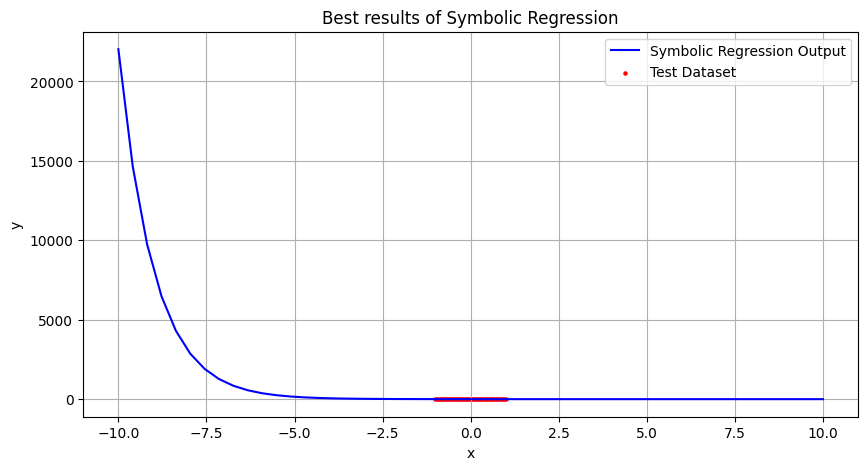

In [67]:

# 6) Plot true vs predicted (example fixing all but x1)
import matplotlib.pyplot as plt

plot_symbolic(x1_values, y_values, string_pred.replace("x4", "x_1").replace("exp", "np.exp").replace("sin", "np.sin"))

In [ ]:
# Second Dataset

C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

# Make tabular dataset

dataset[:, 0] = #TODO
dataset[:, 1] =  #TODO
dataset[:, 2] =  #TODO

# use evaluate function to find the expression
sympy_pred, string_pred = evaluate(dataset)
print(string_pred)

((C)*(x1))*((x2)**2)


In [ ]:
# Parameter optimization using mse loss

In [ ]:
# Plot the results on two datasets.